# LB 0.633349
v4版疑惑
1. v4: df_full->FE try df_train -> FE ??

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,cross_validate,train_test_split

from sklearn.metrics import confusion_matrix,f1_score
import time
import random
import os
import sys


# from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
#                               GradientBoostingClassifier, ExtraTreesClassifier)
# import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


path_raw_data = r'C:\Users\sam32564\raw_data_credit'
# path_processed_data = '../Data/processed'
# path_prediction_data = '../Data/predictions'
col_target = 'fraud_ind'
col_id = 'txkey'
pd.options.display.max_columns=None

# 1. loading data

In [2]:
time_start = time.time()
df = pd.read_csv(os.path.join(path_raw_data, 'train.csv'))
#X = np.array(df_train.drop('fraud_ind',axis=1))
y = np.array(df.fraud_ind)
df_train, df_test, y_train, y_test = train_test_split(df,y,test_size=0.3,random_state=42)
time_end = time.time()
print('spent: {}'.format(time_end-time_start))

spent: 6.561000108718872


In [3]:
df_train_id = df_train[col_id]
df_test_id = df_test[col_id]
target = df_train[col_target]

df_train.drop([col_id], axis = 1, inplace = True)
df_test.drop([col_id], axis = 1, inplace = True)


C:\Users\sam32564\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### drop duplicates

In [4]:
df_train = df_train.drop_duplicates(keep = 'first')
ntrain = df_train.shape[0]

In [5]:
df_full = pd.concat((df_train,df_test),sort = False).reset_index(drop = True)
print(df_train.shape, df_test.shape, df_full.shape)

(1062697, 22) (456537, 22) (1519234, 22)


# 2. EDA

# 3. preprocessing

In [6]:
# generate time feature ( format hhmmss)
df_full['loctm_time'] = df_full['loctm'].apply(lambda x: '0'*(6 - len(str(int(x)))) + str(int(x)))
df_full['loctm_time'] = df_full['loctm_time'].apply(lambda x: x[:2] + ':' + x[2:4] + ':' + x[4:])
df_full['loctm_time'] = pd.to_datetime(df_full['loctm_time'], format='%H:%M:%S')

In [7]:
df_full.insert(3,'time_hour', df_full['loctm_time'].dt.hour)
df_full.insert(3,'time_min', df_full['loctm_time'].dt.minute)
df_full.insert(3,'time_sec', df_full['loctm_time'].dt.second)

In [8]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time
0,6557,51892,58488,8,6,21,497.33,5,62,N,4,N,N,0,5,N,0,50,210608.0,251,31635,N,5817,102,0,1900-01-01 21:06:08
1,5975,65754,58218,12,3,12,718.77,5,62,N,4,N,N,0,5,N,0,85,120312.0,193,99026,N,5817,102,0,1900-01-01 12:03:12
2,6716,163544,117141,39,1,18,807.34,5,62,Y,2,N,N,0,5,N,0,6,180139.0,57,34227,N,5820,102,0,1900-01-01 18:01:39
3,6716,52788,8114,39,57,9,1110.00,4,62,N,2,N,N,0,5,N,0,5,95739.0,317,35002,N,5817,102,0,1900-01-01 09:57:39
4,6716,62527,147619,32,57,15,669.38,5,62,N,5,N,N,0,5,N,0,25,155732.0,247,48833,N,5859,102,0,1900-01-01 15:57:32


# 4. Feature Engineering

## 4.1 generate columns using conam

## 4.1.1 Groupby bacno, locdt, loctm

In [16]:
# 這版先把4.1.1拿掉

## 4.1.2 Groupby bacno

In [9]:
bycol_num = 1
df_full_groupby = df_full.groupby(['bacno']).agg(
    {'conam':['max','min','sum','count','mean','median']})

df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)

In [10]:
col_feature = df_full_groupby.columns.tolist()
for i in range(len(col_feature[bycol_num:])):
    col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno'

df_full_groupby.columns = col_feature

In [11]:
df_full = df_full.merge(df_full_groupby, on = ['bacno'], how = 'left')

In [12]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time,max_bybacno,min_bybacno,sum_bybacno,count_bybacno,mean_bybacno,median_bybacno
0,6557,51892,58488,8,6,21,497.33,5,62,N,4,N,N,0,5,N,0,50,210608.0,251,31635,N,5817,102,0,1900-01-01 21:06:08,1271.91,373.76,11531.74,16,720.733750,659.12
1,5975,65754,58218,12,3,12,718.77,5,62,N,4,N,N,0,5,N,0,85,120312.0,193,99026,N,5817,102,0,1900-01-01 12:03:12,1217.35,535.31,6637.80,8,829.725000,718.77
2,6716,163544,117141,39,1,18,807.34,5,62,Y,2,N,N,0,5,N,0,6,180139.0,57,34227,N,5820,102,0,1900-01-01 18:01:39,1465.15,241.54,23772.31,35,679.208857,697.12
3,6716,52788,8114,39,57,9,1110.00,4,62,N,2,N,N,0,5,N,0,5,95739.0,317,35002,N,5817,102,0,1900-01-01 09:57:39,1555.60,634.68,23726.14,20,1186.307000,1200.82
4,6716,62527,147619,32,57,15,669.38,5,62,N,5,N,N,0,5,N,0,25,155732.0,247,48833,N,5859,102,0,1900-01-01 15:57:32,1130.89,240.27,27546.19,41,671.858293,680.57


## 4.1.3 Groupby bacno with other feature

In [13]:
col_FE = ['time_hour','cano','contp', 'etymd', 'mchno',
          'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
bycol_num = 2

for col in col_FE:
    df_full_groupby = df_full.groupby(['bacno',col]).agg(
        {'conam':['max','min','sum','count','mean','median']})
    
    df_full_groupby.columns = df_full_groupby.columns.droplevel()
    df_full_groupby.reset_index(inplace = True)
    col_feature = df_full_groupby.columns.tolist()
    for i in range(len(col_feature[bycol_num:])):
        col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno_by' + col
    
    df_full_groupby.columns = col_feature
    # Merge Data
    df_full = df_full.merge(df_full_groupby, on = ['bacno',col], how = 'left')

In [14]:
%%time
df_full_groupby = df_full.groupby(['bacno',col]).agg(
    {'conam':['max','min','sum','count','mean','median']})

df_full_groupby.columns = df_full_groupby.columns.droplevel()
df_full_groupby.reset_index(inplace = True)
col_feature = df_full_groupby.columns.tolist()
for i in range(len(col_feature[bycol_num:])):
    col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno_by' + col

df_full_groupby.columns = col_feature

Wall time: 2.59 s


In [15]:
%%time
df_full = df_full.merge(df_full_groupby, on = ['bacno',col], how = 'left')

Wall time: 24.5 s


In [16]:
df_full.to_pickle('df_full.pkl')

In [95]:
df_full = pd.read_pickle('df_full.pkl')

## 4.1.4 Groupby bacno and stocn with other feature

In [4]:
col_FE = ['time_hour','cano','contp', 'etymd', 'mchno',
          'acqic', 'mcc', 'scity', 'stscd', 'csmcu']
bycol_num = 3


for col in col_FE:
    df_full_groupby = df_full.groupby(['bacno','stocn',col]).agg(
        {'conam':['max','min','sum','count','mean','median']})
    
    df_full_groupby.columns = df_full_groupby.columns.droplevel()
    df_full_groupby.reset_index(inplace = True)
    col_feature = df_full_groupby.columns.tolist()
    for i in range(len(col_feature[bycol_num:])):
        col_feature[bycol_num+i] = col_feature[bycol_num+i] + '_bybacno_bystocn_by' + col
    
    df_full_groupby.columns = col_feature
    
    # Merge Data
    df_full = df_full.merge(df_full_groupby, on = ['bacno','stocn',col], how = 'left')

In [5]:
df_full.head()

,acqic,bacno,cano,time_sec,time_min,time_hour,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,loctm_time,max_bybacno,min_bybacno,sum_bybacno,count_bybacno,mean_bybacno,median_bybacno,max_bybacno_bytime_hour,min_bybacno_bytime_hour,sum_bybacno_bytime_hour,count_bybacno_bytime_hour,mean_bybacno_bytime_hour,median_bybacno_bytime_hour,max_bybacno_bycano,min_bybacno_bycano,sum_bybacno_bycano,count_bybacno_bycano,mean_bybacno_bycano,median_bybacno_bycano,max_bybacno_bycontp,min_bybacno_bycontp,sum_bybacno_bycontp,count_bybacno_bycontp,mean_bybacno_bycontp,median_bybacno_bycontp,max_bybacno_byetymd,min_bybacno_byetymd,sum_bybacno_byetymd,count_bybacno_byetymd,mean_bybacno_byetymd,median_bybacno_byetymd,max_bybacno_bymchno,min_bybacno_bymchno,sum_bybacno_bymchno,count_bybacno_bymchno,mean_bybacno_bymchno,median_bybacno_bymchno,max_bybacno_byacqic,min_bybacno_byacqic,sum_bybacno_byacqic,count_bybacno_byacqic,mean_bybacno_byacqic,median_bybacno_byacqic,max_bybacno_bymcc,min_bybacno_bymcc,sum_bybacno_bymcc,count_bybacno_bymcc,mean_bybacno_bymcc,median_bybacno_bymcc,max_bybacno_bystocn,min_bybacno_bystocn,sum_bybacno_bystocn,count_bybacno_bystocn,mean_bybacno_bystocn,median_bybacno_bystocn,max_bybacno_byscity,min_bybacno_byscity,sum_bybacno_byscity,count_bybacno_byscity,mean_bybacno_byscity,median_bybacno_byscity,max_bybacno_bystscd,min_bybacno_bystscd,sum_bybacno_bystscd,count_bybacno_bystscd,mean_bybacno_bystscd,median_bybacno_bystscd,max_bybacno_bycsmcu_x,min_bybacno_bycsmcu_x,sum_bybacno_bycsmcu_x,count_bybacno_bycsmcu_x,mean_bybacno_bycsmcu_x,median_bybacno_bycsmcu_x,max_bybacno_bycsmcu_y,min_bybacno_bycsmcu_y,sum_bybacno_bycsmcu_y,count_bybacno_bycsmcu_y,mean_bybacno_bycsmcu_y,median_bybacno_bycsmcu_y,max_bybacno_bystocn_bytime_hour,min_bybacno_bystocn_bytime_hour,sum_bybacno_bystocn_bytime_hour,count_bybacno_bystocn_bytime_hour,mean_bybacno_bystocn_bytime_hour,median_bybacno_bystocn_bytime_hour,max_bybacno_bystocn_bycano,min_bybacno_bystocn_bycano,sum_bybacno_bystocn_bycano,count_bybacno_bystocn_bycano,mean_bybacno_bystocn_bycano,median_bybacno_bystocn_bycano,max_bybacno_bystocn_bycontp,min_bybacno_bystocn_bycontp,sum_bybacno_bystocn_bycontp,count_bybacno_bystocn_bycontp,mean_bybacno_bystocn_bycontp,median_bybacno_bystocn_bycontp,max_bybacno_bystocn_byetymd,min_bybacno_bystocn_byetymd,sum_bybacno_bystocn_byetymd,count_bybacno_bystocn_byetymd,mean_bybacno_bystocn_byetymd,median_bybacno_bystocn_byetymd,max_bybacno_bystocn_bymchno,min_bybacno_bystocn_bymchno,sum_bybacno_bystocn_bymchno,count_bybacno_bystocn_bymchno,mean_bybacno_bystocn_bymchno,median_bybacno_bystocn_bymchno,max_bybacno_bystocn_byacqic,min_bybacno_bystocn_byacqic,sum_bybacno_bystocn_byacqic,count_bybacno_bystocn_byacqic,mean_bybacno_bystocn_byacqic,median_bybacno_bystocn_byacqic,max_bybacno_bystocn_bymcc,min_bybacno_bystocn_bymcc,sum_bybacno_bystocn_bymcc,count_bybacno_bystocn_bymcc,mean_bybacno_bystocn_bymcc,median_bybacno_bystocn_bymcc,max_bybacno_bystocn_byscity,min_bybacno_bystocn_byscity,sum_bybacno_bystocn_byscity,count_bybacno_bystocn_byscity,mean_bybacno_bystocn_byscity,median_bybacno_bystocn_byscity,max_bybacno_bystocn_bystscd,min_bybacno_bystocn_bystscd,sum_bybacno_bystocn_bystscd,count_bybacno_bystocn_bystscd,mean_bybacno_bystocn_bystscd,median_bybacno_bystocn_bystscd,max_bybacno_bystocn_bycsmcu,min_bybacno_bystocn_bycsmcu,sum_bybacno_bystocn_bycsmcu,count_bybacno_bystocn_bycsmcu,mean_bybacno_bystocn_bycsmcu,median_bybacno_bystocn_bycsmcu
0,6557,51892,58488,8,6,21,497.33,5,62,N,4,N,N,0,5,N,0,50,210608.0,251,31635,N,5817,102,0,1900-01-01 21:06:08,1271.91,373.76,11531.74,16,720.733750,659.12,497.33,373.76,871.09,2,435.545000,435.545,1271.91,373.76,11531.74,16,720.733750,659.12,1271.91,373.76,11531.74,16,720.733750,659.120,1271.91,497.33,8146.60,11,740.600000,633.760,497.33,497.33,497.33,1,497.3300,497.330,497.33,497.33,497.33,1,497.330000,497.330,497.33,497.33,497.33,1,497.330000,497.330,12

## 4.2 create new categorical features

## 4.3 Encoding

### 4.3.1 Frequency Encoding: 
Categorical Feature: ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu'] 代表該值出現的頻率 by bacno

In [27]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['bacno',col]).size() / df_full.groupby(['bacno']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_bacno_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['bacno',col], how ='left')

In [28]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'scity', 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['stocn',col]).size() / df_full.groupby(['stocn']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_stocn_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['stocn',col], how ='left')

In [29]:
frequency_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                               'acqic', 'mcc', 'stocn' , 'stscd', 'csmcu']
for col in frequency_encoding_features:
    frequency = df_full.groupby(['scity',col]).size() / df_full.groupby(['scity']).size()
    frequency = pd.DataFrame(frequency)
    frequency.reset_index(inplace = True)
    frequency.rename(columns = {0: 'fre_scity_{}'.format(col)},inplace = True)
    
    df_full = df_full.merge(frequency, on = ['scity',col], how ='left')

### 4.3.2 Mean encoding 
Categorical Feature: ['contp', 'etymd', 'mchno', 'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']   
target:conam

#### mean for all conam 

In [30]:
mean_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                          'acqic', 'mcc', 'stocn', 'scity', 'stscd', 'csmcu']

In [31]:
for col in mean_encoding_features:
    # 舊版的FE是用df_train(from train data feature to test data)
    mean_encoder = df_full.groupby([col])['conam'].mean()
    df_full.loc[:, 'mean_encoding_{}'.format(col)] = df_full[col].map(mean_encoder)

#### mean by stocn for all conam

In [32]:
mean_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                          'acqic', 'mcc', 'scity', 'stscd', 'csmcu']

In [33]:
for col in mean_encoding_features:
    # 舊版的FE是用df_train
    mean_encoder = df_full.groupby(['stocn',col])['conam'].mean()
    df_full.loc[:, 'mean_encoding_bystocn_{}'.format(col)] = df_full[col].map(mean_encoder)

#### mean by scity for all conam

In [34]:
mean_encoding_features = ['time_hour','contp', 'etymd', 'mchno',
                          'acqic', 'mcc','stocn', 'stscd', 'csmcu']

In [35]:
for col in mean_encoding_features:
    # 舊版的FE是用df_train
    mean_encoder = df_full.groupby(['scity',col])['conam'].mean()
    df_full.loc[:, 'mean_encoding_byscity_{}'.format(col)] = df_full[col].map(mean_encoder)

### 4.3.3 Onehot encoding

In [ ]:
df_full = pd.get_dummies(df_full)

### Fillna

In [ ]:
# Fill NaN, 此处排除 fraud_ind
for col in df_full.columns:
    if col != 'fraud_ind':
        df_full[col] = df_full[col].fillna(0)

In [ ]:
df_full['fraud_ind'].isnull().sum()

### drop columns

In [ ]:
df_full.columns

In [ ]:
# 檢查有na的columns
df_full.loc[:,df_full.columns[df_full.isnull().sum()>0]].isnull().sum()

In [ ]:
df_full.drop(['bacno','cano','locdt','loctm','time_sec','time_min','loctm_time',
             ],axis=1,inplace=True)

In [ ]:
print(df_full.shape)
df_full.head()

# 5. Split train and test set

In [ ]:
ntrain

In [ ]:
df_train_mart = df_full[: ntrain].copy()
df_test_mart = df_full[ntrain:].copy()
print(df_train_mart.shape,df_test_mart.shape)

In [ ]:
df_test_mart.drop([col_target], axis = 1, inplace = True)

In [ ]:
df_train_X = df_train_mart.loc[:, df_train_mart.columns != col_target]
df_train_y = df_train_mart.loc[:, df_train_mart.columns == col_target]

In [ ]:
print(df_train_X.shape)
df_train_X.head()

# 6. CV 

## 6.1 xgbboost

In [41]:
# SEED = 0
# NFOLDS = 10
# #Kf = KFold(NFOLDS , random_state=SEED,shuffle=True)
# Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
# x_train = df_train_X
# y_train = df_train_y
# x_test = df_test_mart
# te_index ={}
# y_te = {}
# pred_pro = {}
# meta_y = np.zeros((len(x_test),NFOLDS))
# tStart = time.time()
# i = 0
# for train_index, test_index in Kf.split(x_train,y_train):
#     te_index[i] = test_index
#     x_tr = df_train_X.iloc[train_index]
#     y_tr = df_train_y.iloc[train_index]
#     x_te = df_train_X.iloc[test_index]
#     y_te[i] = df_train_y.iloc[test_index]
#     clf_cv = xgb.XGBClassifier(n_jobs=-1)
#     clf_cv.fit(x_tr, y_tr)
#     pred_pro[i] = clf_cv.predict_proba(x_te)[:,1]
#     meta_y[:,i] = clf_cv.predict_proba(df_test_mart)[:,1]
#     print('fold complete:',i+1)
#     print('target ratio:',y_tr.mean())
#     i = i+1

# tEnd = time.time()
# print('Time CV (s):',tEnd-tStart)

In [42]:
# threshold = np.arange(0.1,0.95,0.05)
# f1_df_xgb = pd.DataFrame()
# w = 0
# for thres in threshold:
#     for i in range(NFOLDS):
#         f1_df_xgb.loc[w,'threshold'] = thres
#         f1_df_xgb.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
#         w = w + 1

# f1_mean_xgb = f1_df_xgb.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

# f1_std_xgb = f1_df_xgb.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)

In [43]:
# print('threshold:',f1_mean_xgb['threshold'].values)
# print('mean:',f1_mean_xgb['f1_score'].values)
# print('std:',f1_std_xgb.loc[f1_mean_xgb.index,'f1_score'].values)

In [44]:
# clf = xgb.XGBClassifier(n_jobs=-1)
# clf.fit(df_train_X, df_train_y)

In [45]:
# pred_pro4sub = clf.predict_proba(df_test_mart)[:,1]

## 6.2 Catboost

In [46]:
# cv catboost
# 看似fit裡面只能餵df?

SEED = 8787
NFOLDS = 10
cat_features = [0, 1]
#Kf = KFold(NFOLDS , random_state=SEED,shuffle=True)
Kf = StratifiedKFold(NFOLDS,random_state=SEED,shuffle=True)
x_train = df_train_X
y_train = df_train_y
x_test = df_test_mart
te_index ={}
y_te = {}
pred_pro = {}
meta_y = np.zeros((len(x_test),NFOLDS))
tStart = time.time()
i = 0
for train_index, test_index in Kf.split(x_train,y_train):
    te_index[i] = test_index
    x_tr = df_train_X.iloc[train_index]
    y_tr = df_train_y.iloc[train_index]
    x_te = df_train_X.iloc[test_index]
    y_te[i] = df_train_y.iloc[test_index]
    clf_cv = CatBoostClassifier(loss_function='Logloss',verbose=True)
    clf_cv.fit(x_tr, y_tr)
    pred_pro[i] = clf_cv.predict_proba(x_te)[:,1]
    meta_y[:,i] = clf_cv.predict_proba(df_test_mart)[:,1]
    print('fold complete:',i+1)
    print('target ratio:',y_tr.mean())
    i = i+1

tEnd = time.time()
print('Time CV (s):',tEnd-tStart)

Learning rate set to 0.193051
0:	learn: 0.2867048	total: 2.55s	remaining: 42m 26s
1:	learn: 0.1376227	total: 3.42s	remaining: 28m 25s
2:	learn: 0.0842044	total: 4.29s	remaining: 23m 44s
3:	learn: 0.0607376	total: 5.06s	remaining: 21m 1s
4:	learn: 0.0491663	total: 5.79s	remaining: 19m 12s
5:	learn: 0.0427785	total: 6.52s	remaining: 18m
6:	learn: 0.0385163	total: 7.41s	remaining: 17m 31s
7:	learn: 0.0361259	total: 8.22s	remaining: 16m 58s
8:	learn: 0.0349730	total: 9.18s	remaining: 16m 50s
9:	learn: 0.0340493	total: 9.89s	remaining: 16m 18s
20:	learn: 0.0294626	total: 18.1s	remaining: 14m 2s
21:	learn: 0.0293134	total: 18.7s	remaining: 13m 51s
22:	learn: 0.0291061	total: 19.3s	remaining: 13m 40s
23:	learn: 0.0288139	total: 20.2s	remaining: 13m 41s
24:	learn: 0.0286525	total: 20.9s	remaining: 13m 35s
25:	learn: 0.0284642	total: 21.5s	remaining: 13m 26s
26:	learn: 0.0283188	total: 22.3s	remaining: 13m 24s
27:	learn: 0.0282209	total: 23s	remaining: 13m 17s
28:	learn: 0.0280877	total: 23.9s	

163:	learn: 0.0198459	total: 2m 1s	remaining: 10m 20s
164:	learn: 0.0198012	total: 2m 2s	remaining: 10m 20s
165:	learn: 0.0197716	total: 2m 3s	remaining: 10m 19s
166:	learn: 0.0197348	total: 2m 3s	remaining: 10m 17s
167:	learn: 0.0197168	total: 2m 4s	remaining: 10m 16s
168:	learn: 0.0196774	total: 2m 5s	remaining: 10m 15s
169:	learn: 0.0196571	total: 2m 5s	remaining: 10m 14s
170:	learn: 0.0196434	total: 2m 6s	remaining: 10m 13s
171:	learn: 0.0196225	total: 2m 7s	remaining: 10m 12s
172:	learn: 0.0195913	total: 2m 7s	remaining: 10m 11s
173:	learn: 0.0195650	total: 2m 8s	remaining: 10m 10s
174:	learn: 0.0195180	total: 2m 9s	remaining: 10m 10s
175:	learn: 0.0194916	total: 2m 10s	remaining: 10m 10s
176:	learn: 0.0194555	total: 2m 11s	remaining: 10m 9s
177:	learn: 0.0194171	total: 2m 11s	remaining: 10m 8s
178:	learn: 0.0193825	total: 2m 12s	remaining: 10m 8s
179:	learn: 0.0193595	total: 2m 13s	remaining: 10m 7s
180:	learn: 0.0193214	total: 2m 14s	remaining: 10m 7s
181:	learn: 0.0192956	total

316:	learn: 0.0164789	total: 3m 52s	remaining: 8m 20s
317:	learn: 0.0164695	total: 3m 52s	remaining: 8m 19s
318:	learn: 0.0164540	total: 3m 53s	remaining: 8m 18s
319:	learn: 0.0164406	total: 3m 54s	remaining: 8m 17s
320:	learn: 0.0164288	total: 3m 54s	remaining: 8m 17s
321:	learn: 0.0164164	total: 3m 55s	remaining: 8m 16s
322:	learn: 0.0164013	total: 3m 56s	remaining: 8m 15s
323:	learn: 0.0163928	total: 3m 57s	remaining: 8m 14s
324:	learn: 0.0163785	total: 3m 57s	remaining: 8m 13s
325:	learn: 0.0163717	total: 3m 58s	remaining: 8m 12s
326:	learn: 0.0163471	total: 3m 59s	remaining: 8m 12s
327:	learn: 0.0163276	total: 3m 59s	remaining: 8m 11s
328:	learn: 0.0163176	total: 4m	remaining: 8m 10s
329:	learn: 0.0163098	total: 4m 1s	remaining: 8m 9s
330:	learn: 0.0162934	total: 4m 1s	remaining: 8m 8s
331:	learn: 0.0162797	total: 4m 2s	remaining: 8m 7s
332:	learn: 0.0162646	total: 4m 3s	remaining: 8m 7s
333:	learn: 0.0162511	total: 4m 3s	remaining: 8m 6s
334:	learn: 0.0162385	total: 4m 4s	remaini

470:	learn: 0.0142935	total: 5m 43s	remaining: 6m 25s
471:	learn: 0.0142911	total: 5m 44s	remaining: 6m 24s
472:	learn: 0.0142725	total: 5m 44s	remaining: 6m 24s
473:	learn: 0.0142602	total: 5m 45s	remaining: 6m 23s
474:	learn: 0.0142515	total: 5m 46s	remaining: 6m 22s
475:	learn: 0.0142356	total: 5m 46s	remaining: 6m 21s
476:	learn: 0.0142251	total: 5m 47s	remaining: 6m 21s
477:	learn: 0.0142116	total: 5m 48s	remaining: 6m 20s
478:	learn: 0.0141957	total: 5m 49s	remaining: 6m 20s
479:	learn: 0.0141928	total: 5m 50s	remaining: 6m 19s
480:	learn: 0.0141833	total: 5m 50s	remaining: 6m 18s
481:	learn: 0.0141749	total: 5m 51s	remaining: 6m 17s
482:	learn: 0.0141692	total: 5m 52s	remaining: 6m 16s
483:	learn: 0.0141618	total: 5m 52s	remaining: 6m 16s
484:	learn: 0.0141553	total: 5m 53s	remaining: 6m 15s
485:	learn: 0.0141503	total: 5m 54s	remaining: 6m 14s
486:	learn: 0.0141456	total: 5m 54s	remaining: 6m 13s
487:	learn: 0.0141130	total: 5m 55s	remaining: 6m 13s
488:	learn: 0.0141072	total:

624:	learn: 0.0126598	total: 7m 34s	remaining: 4m 32s
625:	learn: 0.0126547	total: 7m 35s	remaining: 4m 32s
626:	learn: 0.0126515	total: 7m 36s	remaining: 4m 31s
627:	learn: 0.0126463	total: 7m 36s	remaining: 4m 30s
628:	learn: 0.0126329	total: 7m 37s	remaining: 4m 29s
629:	learn: 0.0126281	total: 7m 38s	remaining: 4m 29s
630:	learn: 0.0126172	total: 7m 38s	remaining: 4m 28s
631:	learn: 0.0126137	total: 7m 39s	remaining: 4m 27s
632:	learn: 0.0126076	total: 7m 40s	remaining: 4m 26s
633:	learn: 0.0125963	total: 7m 40s	remaining: 4m 26s
634:	learn: 0.0125865	total: 7m 41s	remaining: 4m 25s
635:	learn: 0.0125670	total: 7m 42s	remaining: 4m 24s
636:	learn: 0.0125520	total: 7m 43s	remaining: 4m 23s
637:	learn: 0.0125411	total: 7m 43s	remaining: 4m 23s
638:	learn: 0.0125302	total: 7m 44s	remaining: 4m 22s
639:	learn: 0.0125235	total: 7m 45s	remaining: 4m 21s
640:	learn: 0.0125200	total: 7m 45s	remaining: 4m 20s
641:	learn: 0.0125053	total: 7m 46s	remaining: 4m 20s
642:	learn: 0.0124994	total:

780:	learn: 0.0113201	total: 9m 29s	remaining: 2m 39s
781:	learn: 0.0113077	total: 9m 30s	remaining: 2m 39s
782:	learn: 0.0112924	total: 9m 31s	remaining: 2m 38s
783:	learn: 0.0112759	total: 9m 32s	remaining: 2m 37s
784:	learn: 0.0112658	total: 9m 33s	remaining: 2m 37s
785:	learn: 0.0112557	total: 9m 34s	remaining: 2m 36s
786:	learn: 0.0112474	total: 9m 35s	remaining: 2m 35s
787:	learn: 0.0112436	total: 9m 35s	remaining: 2m 34s
788:	learn: 0.0112312	total: 9m 36s	remaining: 2m 34s
789:	learn: 0.0112261	total: 9m 37s	remaining: 2m 33s
790:	learn: 0.0112186	total: 9m 38s	remaining: 2m 32s
791:	learn: 0.0112159	total: 9m 38s	remaining: 2m 31s
792:	learn: 0.0112067	total: 9m 39s	remaining: 2m 31s
793:	learn: 0.0112030	total: 9m 40s	remaining: 2m 30s
794:	learn: 0.0111975	total: 9m 40s	remaining: 2m 29s
795:	learn: 0.0111929	total: 9m 41s	remaining: 2m 29s
796:	learn: 0.0111822	total: 9m 42s	remaining: 2m 28s
797:	learn: 0.0111626	total: 9m 42s	remaining: 2m 27s
798:	learn: 0.0111480	total:

932:	learn: 0.0101914	total: 11m 25s	remaining: 49.2s
933:	learn: 0.0101871	total: 11m 26s	remaining: 48.5s
934:	learn: 0.0101818	total: 11m 27s	remaining: 47.8s
935:	learn: 0.0101783	total: 11m 27s	remaining: 47s
936:	learn: 0.0101708	total: 11m 28s	remaining: 46.3s
937:	learn: 0.0101651	total: 11m 29s	remaining: 45.6s
938:	learn: 0.0101584	total: 11m 29s	remaining: 44.8s
939:	learn: 0.0101471	total: 11m 30s	remaining: 44.1s
940:	learn: 0.0101384	total: 11m 31s	remaining: 43.4s
941:	learn: 0.0101339	total: 11m 32s	remaining: 42.6s
942:	learn: 0.0101296	total: 11m 32s	remaining: 41.9s
943:	learn: 0.0101256	total: 11m 33s	remaining: 41.2s
944:	learn: 0.0101218	total: 11m 34s	remaining: 40.4s
945:	learn: 0.0101113	total: 11m 35s	remaining: 39.7s
946:	learn: 0.0101059	total: 11m 36s	remaining: 39s
947:	learn: 0.0101004	total: 11m 37s	remaining: 38.2s
948:	learn: 0.0100953	total: 11m 38s	remaining: 37.5s
949:	learn: 0.0100866	total: 11m 38s	remaining: 36.8s
950:	learn: 0.0100813	total: 11m

86:	learn: 0.0230751	total: 1m 3s	remaining: 11m 5s
87:	learn: 0.0230351	total: 1m 4s	remaining: 11m 3s
88:	learn: 0.0229931	total: 1m 4s	remaining: 11m 2s
89:	learn: 0.0229415	total: 1m 5s	remaining: 10m 59s
90:	learn: 0.0229016	total: 1m 6s	remaining: 10m 59s
91:	learn: 0.0228747	total: 1m 6s	remaining: 10m 58s
92:	learn: 0.0228137	total: 1m 7s	remaining: 10m 58s
93:	learn: 0.0227846	total: 1m 8s	remaining: 10m 57s
94:	learn: 0.0226809	total: 1m 9s	remaining: 10m 58s
95:	learn: 0.0226070	total: 1m 9s	remaining: 10m 58s
96:	learn: 0.0225629	total: 1m 10s	remaining: 10m 58s
97:	learn: 0.0225204	total: 1m 11s	remaining: 10m 57s
98:	learn: 0.0224724	total: 1m 12s	remaining: 10m 56s
99:	learn: 0.0224012	total: 1m 12s	remaining: 10m 54s
100:	learn: 0.0223529	total: 1m 13s	remaining: 10m 54s
101:	learn: 0.0222357	total: 1m 14s	remaining: 10m 54s
102:	learn: 0.0221849	total: 1m 15s	remaining: 10m 54s
103:	learn: 0.0221424	total: 1m 15s	remaining: 10m 52s
104:	learn: 0.0220725	total: 1m 16s	r

238:	learn: 0.0178608	total: 2m 54s	remaining: 9m 15s
239:	learn: 0.0178225	total: 2m 55s	remaining: 9m 14s
240:	learn: 0.0178099	total: 2m 55s	remaining: 9m 14s
241:	learn: 0.0177967	total: 2m 56s	remaining: 9m 13s
242:	learn: 0.0177801	total: 2m 57s	remaining: 9m 13s
243:	learn: 0.0177567	total: 2m 58s	remaining: 9m 12s
244:	learn: 0.0177369	total: 2m 59s	remaining: 9m 11s
245:	learn: 0.0177109	total: 3m	remaining: 9m 11s
246:	learn: 0.0176916	total: 3m	remaining: 9m 11s
247:	learn: 0.0176708	total: 3m 1s	remaining: 9m 10s
248:	learn: 0.0176363	total: 3m 2s	remaining: 9m 9s
249:	learn: 0.0176292	total: 3m 2s	remaining: 9m 8s
250:	learn: 0.0176132	total: 3m 3s	remaining: 9m 7s
251:	learn: 0.0175918	total: 3m 4s	remaining: 9m 7s
252:	learn: 0.0175720	total: 3m 5s	remaining: 9m 6s
253:	learn: 0.0175598	total: 3m 5s	remaining: 9m 5s
254:	learn: 0.0175340	total: 3m 6s	remaining: 9m 4s
255:	learn: 0.0175231	total: 3m 7s	remaining: 9m 4s
256:	learn: 0.0175001	total: 3m 8s	remaining: 9m 3s
2

392:	learn: 0.0150071	total: 4m 49s	remaining: 7m 26s
393:	learn: 0.0149952	total: 4m 49s	remaining: 7m 25s
394:	learn: 0.0149876	total: 4m 50s	remaining: 7m 25s
395:	learn: 0.0149707	total: 4m 51s	remaining: 7m 24s
396:	learn: 0.0149482	total: 4m 52s	remaining: 7m 23s
397:	learn: 0.0149143	total: 4m 52s	remaining: 7m 22s
398:	learn: 0.0148858	total: 4m 53s	remaining: 7m 22s
399:	learn: 0.0148698	total: 4m 54s	remaining: 7m 21s
400:	learn: 0.0148563	total: 4m 54s	remaining: 7m 20s
401:	learn: 0.0148442	total: 4m 55s	remaining: 7m 19s
402:	learn: 0.0148290	total: 4m 56s	remaining: 7m 19s
403:	learn: 0.0148162	total: 4m 57s	remaining: 7m 18s
404:	learn: 0.0148022	total: 4m 58s	remaining: 7m 17s
405:	learn: 0.0147946	total: 4m 58s	remaining: 7m 17s
406:	learn: 0.0147761	total: 4m 59s	remaining: 7m 16s
407:	learn: 0.0147737	total: 5m	remaining: 7m 15s
408:	learn: 0.0147613	total: 5m	remaining: 7m 14s
409:	learn: 0.0147557	total: 5m 1s	remaining: 7m 13s
410:	learn: 0.0147384	total: 5m 2s	re

546:	learn: 0.0132205	total: 6m 44s	remaining: 5m 34s
547:	learn: 0.0132089	total: 6m 45s	remaining: 5m 34s
548:	learn: 0.0131980	total: 6m 45s	remaining: 5m 33s
549:	learn: 0.0131860	total: 6m 46s	remaining: 5m 32s
550:	learn: 0.0131742	total: 6m 47s	remaining: 5m 31s
551:	learn: 0.0131556	total: 6m 48s	remaining: 5m 31s
552:	learn: 0.0131431	total: 6m 48s	remaining: 5m 30s
553:	learn: 0.0131314	total: 6m 49s	remaining: 5m 29s
554:	learn: 0.0131226	total: 6m 50s	remaining: 5m 29s
555:	learn: 0.0131033	total: 6m 51s	remaining: 5m 28s
556:	learn: 0.0130935	total: 6m 51s	remaining: 5m 27s
557:	learn: 0.0130919	total: 6m 52s	remaining: 5m 26s
558:	learn: 0.0130805	total: 6m 53s	remaining: 5m 26s
559:	learn: 0.0130686	total: 6m 54s	remaining: 5m 25s
560:	learn: 0.0130553	total: 6m 55s	remaining: 5m 24s
561:	learn: 0.0130444	total: 6m 55s	remaining: 5m 24s
562:	learn: 0.0130386	total: 6m 56s	remaining: 5m 23s
563:	learn: 0.0130298	total: 6m 57s	remaining: 5m 22s
564:	learn: 0.0130168	total:

700:	learn: 0.0116894	total: 8m 43s	remaining: 3m 43s
701:	learn: 0.0116865	total: 8m 44s	remaining: 3m 42s
702:	learn: 0.0116724	total: 8m 44s	remaining: 3m 41s
703:	learn: 0.0116651	total: 8m 45s	remaining: 3m 41s
704:	learn: 0.0116552	total: 8m 46s	remaining: 3m 40s
705:	learn: 0.0116512	total: 8m 47s	remaining: 3m 39s
706:	learn: 0.0116361	total: 8m 48s	remaining: 3m 38s
707:	learn: 0.0116282	total: 8m 48s	remaining: 3m 38s
708:	learn: 0.0116186	total: 8m 49s	remaining: 3m 37s
709:	learn: 0.0115999	total: 8m 50s	remaining: 3m 36s
710:	learn: 0.0115865	total: 8m 51s	remaining: 3m 35s
711:	learn: 0.0115737	total: 8m 51s	remaining: 3m 35s
712:	learn: 0.0115631	total: 8m 52s	remaining: 3m 34s
713:	learn: 0.0115580	total: 8m 53s	remaining: 3m 33s
714:	learn: 0.0115498	total: 8m 53s	remaining: 3m 32s
715:	learn: 0.0115413	total: 8m 54s	remaining: 3m 32s
716:	learn: 0.0115326	total: 8m 55s	remaining: 3m 31s
717:	learn: 0.0115241	total: 8m 56s	remaining: 3m 30s
718:	learn: 0.0115137	total:

853:	learn: 0.0104062	total: 10m 39s	remaining: 1m 49s
854:	learn: 0.0103934	total: 10m 40s	remaining: 1m 48s
855:	learn: 0.0103793	total: 10m 41s	remaining: 1m 47s
856:	learn: 0.0103665	total: 10m 42s	remaining: 1m 47s
857:	learn: 0.0103593	total: 10m 42s	remaining: 1m 46s
858:	learn: 0.0103468	total: 10m 43s	remaining: 1m 45s
859:	learn: 0.0103453	total: 10m 44s	remaining: 1m 44s
860:	learn: 0.0103303	total: 10m 44s	remaining: 1m 44s
861:	learn: 0.0103237	total: 10m 45s	remaining: 1m 43s
862:	learn: 0.0103040	total: 10m 46s	remaining: 1m 42s
863:	learn: 0.0102993	total: 10m 47s	remaining: 1m 41s
864:	learn: 0.0102968	total: 10m 47s	remaining: 1m 41s
865:	learn: 0.0102937	total: 10m 48s	remaining: 1m 40s
866:	learn: 0.0102888	total: 10m 49s	remaining: 1m 39s
867:	learn: 0.0102756	total: 10m 50s	remaining: 1m 38s
868:	learn: 0.0102704	total: 10m 50s	remaining: 1m 38s
869:	learn: 0.0102648	total: 10m 51s	remaining: 1m 37s
870:	learn: 0.0102577	total: 10m 52s	remaining: 1m 36s
871:	learn

4:	learn: 0.0494985	total: 3.74s	remaining: 12m 24s
5:	learn: 0.0428147	total: 4.38s	remaining: 12m 5s
6:	learn: 0.0388886	total: 5.13s	remaining: 12m 8s
7:	learn: 0.0363089	total: 5.81s	remaining: 12m
8:	learn: 0.0351865	total: 6.52s	remaining: 11m 58s
9:	learn: 0.0345354	total: 7.13s	remaining: 11m 46s
10:	learn: 0.0338372	total: 7.75s	remaining: 11m 36s
11:	learn: 0.0331182	total: 8.44s	remaining: 11m 35s
12:	learn: 0.0326957	total: 9.12s	remaining: 11m 32s
13:	learn: 0.0318563	total: 9.91s	remaining: 11m 38s
14:	learn: 0.0314508	total: 10.7s	remaining: 11m 39s
15:	learn: 0.0310811	total: 11.3s	remaining: 11m 36s
16:	learn: 0.0307930	total: 12.1s	remaining: 11m 41s
17:	learn: 0.0305061	total: 13s	remaining: 11m 47s
18:	learn: 0.0301752	total: 13.6s	remaining: 11m 41s
19:	learn: 0.0299524	total: 14.2s	remaining: 11m 35s
20:	learn: 0.0298447	total: 14.8s	remaining: 11m 29s
21:	learn: 0.0295967	total: 15.5s	remaining: 11m 30s
22:	learn: 0.0294353	total: 16.1s	remaining: 11m 24s
23:	lea

158:	learn: 0.0198991	total: 1m 55s	remaining: 10m 13s
159:	learn: 0.0198648	total: 1m 56s	remaining: 10m 12s
160:	learn: 0.0198253	total: 1m 57s	remaining: 10m 11s
161:	learn: 0.0197613	total: 1m 58s	remaining: 10m 10s
162:	learn: 0.0197193	total: 1m 58s	remaining: 10m 10s
163:	learn: 0.0196914	total: 1m 59s	remaining: 10m 9s
164:	learn: 0.0196708	total: 2m	remaining: 10m 8s
165:	learn: 0.0196515	total: 2m	remaining: 10m 7s
166:	learn: 0.0196112	total: 2m 1s	remaining: 10m 6s
167:	learn: 0.0195876	total: 2m 2s	remaining: 10m 4s
168:	learn: 0.0195576	total: 2m 3s	remaining: 10m 5s
169:	learn: 0.0195328	total: 2m 3s	remaining: 10m 4s
170:	learn: 0.0195231	total: 2m 4s	remaining: 10m 3s
171:	learn: 0.0194868	total: 2m 5s	remaining: 10m 2s
172:	learn: 0.0194692	total: 2m 5s	remaining: 10m 2s
173:	learn: 0.0194357	total: 2m 6s	remaining: 10m 1s
174:	learn: 0.0194084	total: 2m 7s	remaining: 10m
175:	learn: 0.0193799	total: 2m 7s	remaining: 9m 58s
176:	learn: 0.0193302	total: 2m 8s	remaining

311:	learn: 0.0163539	total: 3m 47s	remaining: 8m 21s
312:	learn: 0.0163457	total: 3m 48s	remaining: 8m 20s
313:	learn: 0.0163325	total: 3m 48s	remaining: 8m 19s
314:	learn: 0.0163143	total: 3m 49s	remaining: 8m 19s
315:	learn: 0.0162973	total: 3m 50s	remaining: 8m 18s
316:	learn: 0.0162900	total: 3m 51s	remaining: 8m 17s
317:	learn: 0.0162687	total: 3m 51s	remaining: 8m 17s
318:	learn: 0.0162489	total: 3m 52s	remaining: 8m 16s
319:	learn: 0.0162241	total: 3m 53s	remaining: 8m 15s
320:	learn: 0.0161992	total: 3m 53s	remaining: 8m 14s
321:	learn: 0.0161897	total: 3m 54s	remaining: 8m 14s
322:	learn: 0.0161643	total: 3m 55s	remaining: 8m 14s
323:	learn: 0.0161366	total: 3m 56s	remaining: 8m 13s
324:	learn: 0.0161245	total: 3m 57s	remaining: 8m 12s
325:	learn: 0.0160911	total: 3m 58s	remaining: 8m 12s
326:	learn: 0.0160858	total: 3m 58s	remaining: 8m 11s
327:	learn: 0.0160678	total: 3m 59s	remaining: 8m 10s
328:	learn: 0.0160569	total: 4m	remaining: 8m 9s
329:	learn: 0.0160444	total: 4m	r

465:	learn: 0.0140262	total: 5m 41s	remaining: 6m 30s
466:	learn: 0.0140149	total: 5m 41s	remaining: 6m 29s
467:	learn: 0.0139959	total: 5m 42s	remaining: 6m 29s
468:	learn: 0.0139777	total: 5m 43s	remaining: 6m 28s
469:	learn: 0.0139624	total: 5m 43s	remaining: 6m 27s
470:	learn: 0.0139517	total: 5m 44s	remaining: 6m 27s
471:	learn: 0.0139449	total: 5m 45s	remaining: 6m 26s
472:	learn: 0.0139261	total: 5m 46s	remaining: 6m 25s
473:	learn: 0.0139146	total: 5m 46s	remaining: 6m 24s
474:	learn: 0.0138974	total: 5m 47s	remaining: 6m 24s
475:	learn: 0.0138823	total: 5m 48s	remaining: 6m 23s
476:	learn: 0.0138722	total: 5m 49s	remaining: 6m 23s
477:	learn: 0.0138637	total: 5m 50s	remaining: 6m 22s
478:	learn: 0.0138486	total: 5m 50s	remaining: 6m 21s
479:	learn: 0.0138378	total: 5m 51s	remaining: 6m 20s
480:	learn: 0.0138211	total: 5m 52s	remaining: 6m 20s
481:	learn: 0.0138030	total: 5m 52s	remaining: 6m 19s
482:	learn: 0.0137969	total: 5m 53s	remaining: 6m 18s
483:	learn: 0.0137868	total:

619:	learn: 0.0124283	total: 7m 34s	remaining: 4m 38s
620:	learn: 0.0124220	total: 7m 35s	remaining: 4m 37s
621:	learn: 0.0124074	total: 7m 36s	remaining: 4m 37s
622:	learn: 0.0123954	total: 7m 36s	remaining: 4m 36s
623:	learn: 0.0123864	total: 7m 37s	remaining: 4m 35s
624:	learn: 0.0123847	total: 7m 38s	remaining: 4m 34s
625:	learn: 0.0123743	total: 7m 38s	remaining: 4m 34s
626:	learn: 0.0123690	total: 7m 39s	remaining: 4m 33s
627:	learn: 0.0123548	total: 7m 40s	remaining: 4m 32s
628:	learn: 0.0123465	total: 7m 40s	remaining: 4m 31s
629:	learn: 0.0123307	total: 7m 41s	remaining: 4m 31s
630:	learn: 0.0123254	total: 7m 42s	remaining: 4m 30s
631:	learn: 0.0123105	total: 7m 43s	remaining: 4m 29s
632:	learn: 0.0123059	total: 7m 44s	remaining: 4m 29s
633:	learn: 0.0123041	total: 7m 44s	remaining: 4m 28s
634:	learn: 0.0122945	total: 7m 45s	remaining: 4m 27s
635:	learn: 0.0122876	total: 7m 45s	remaining: 4m 26s
636:	learn: 0.0122767	total: 7m 46s	remaining: 4m 25s
637:	learn: 0.0122678	total:

773:	learn: 0.0111663	total: 9m 28s	remaining: 2m 46s
774:	learn: 0.0111625	total: 9m 29s	remaining: 2m 45s
775:	learn: 0.0111568	total: 9m 30s	remaining: 2m 44s
776:	learn: 0.0111538	total: 9m 31s	remaining: 2m 43s
777:	learn: 0.0111457	total: 9m 31s	remaining: 2m 43s
778:	learn: 0.0111425	total: 9m 32s	remaining: 2m 42s
779:	learn: 0.0111290	total: 9m 33s	remaining: 2m 41s
780:	learn: 0.0111223	total: 9m 34s	remaining: 2m 40s
781:	learn: 0.0111080	total: 9m 34s	remaining: 2m 40s
782:	learn: 0.0111051	total: 9m 35s	remaining: 2m 39s
783:	learn: 0.0110988	total: 9m 36s	remaining: 2m 38s
784:	learn: 0.0110949	total: 9m 36s	remaining: 2m 37s
785:	learn: 0.0110852	total: 9m 37s	remaining: 2m 37s
786:	learn: 0.0110761	total: 9m 37s	remaining: 2m 36s
787:	learn: 0.0110596	total: 9m 38s	remaining: 2m 35s
788:	learn: 0.0110448	total: 9m 39s	remaining: 2m 35s
789:	learn: 0.0110409	total: 9m 40s	remaining: 2m 34s
790:	learn: 0.0110309	total: 9m 41s	remaining: 2m 33s
791:	learn: 0.0110242	total:

925:	learn: 0.0100533	total: 11m 22s	remaining: 54.5s
926:	learn: 0.0100346	total: 11m 23s	remaining: 53.8s
927:	learn: 0.0100300	total: 11m 23s	remaining: 53.1s
928:	learn: 0.0100276	total: 11m 24s	remaining: 52.3s
929:	learn: 0.0100160	total: 11m 25s	remaining: 51.6s
930:	learn: 0.0100137	total: 11m 26s	remaining: 50.8s
931:	learn: 0.0100066	total: 11m 26s	remaining: 50.1s
932:	learn: 0.0100054	total: 11m 27s	remaining: 49.4s
933:	learn: 0.0100017	total: 11m 28s	remaining: 48.6s
934:	learn: 0.0099980	total: 11m 29s	remaining: 47.9s
935:	learn: 0.0099943	total: 11m 29s	remaining: 47.2s
936:	learn: 0.0099877	total: 11m 30s	remaining: 46.4s
937:	learn: 0.0099824	total: 11m 31s	remaining: 45.7s
938:	learn: 0.0099752	total: 11m 31s	remaining: 45s
939:	learn: 0.0099695	total: 11m 32s	remaining: 44.2s
940:	learn: 0.0099543	total: 11m 33s	remaining: 43.5s
941:	learn: 0.0099526	total: 11m 33s	remaining: 42.7s
942:	learn: 0.0099424	total: 11m 34s	remaining: 42s
943:	learn: 0.0099316	total: 11m

78:	learn: 0.0233359	total: 55.5s	remaining: 10m 46s
79:	learn: 0.0233014	total: 56.1s	remaining: 10m 44s
80:	learn: 0.0232646	total: 56.7s	remaining: 10m 43s
81:	learn: 0.0232252	total: 57.3s	remaining: 10m 41s
82:	learn: 0.0231623	total: 58s	remaining: 10m 40s
83:	learn: 0.0231057	total: 58.9s	remaining: 10m 42s
84:	learn: 0.0230729	total: 59.6s	remaining: 10m 41s
85:	learn: 0.0230209	total: 1m	remaining: 10m 40s
86:	learn: 0.0229578	total: 1m 1s	remaining: 10m 40s
87:	learn: 0.0228778	total: 1m 1s	remaining: 10m 39s
88:	learn: 0.0228410	total: 1m 2s	remaining: 10m 39s
89:	learn: 0.0227861	total: 1m 3s	remaining: 10m 40s
90:	learn: 0.0227366	total: 1m 4s	remaining: 10m 41s
91:	learn: 0.0226782	total: 1m 4s	remaining: 10m 41s
92:	learn: 0.0226236	total: 1m 5s	remaining: 10m 40s
93:	learn: 0.0225623	total: 1m 6s	remaining: 10m 40s
94:	learn: 0.0225369	total: 1m 7s	remaining: 10m 39s
95:	learn: 0.0224942	total: 1m 7s	remaining: 10m 37s
96:	learn: 0.0224459	total: 1m 8s	remaining: 10m 36

230:	learn: 0.0180200	total: 2m 45s	remaining: 9m 12s
231:	learn: 0.0179913	total: 2m 46s	remaining: 9m 11s
232:	learn: 0.0179723	total: 2m 47s	remaining: 9m 11s
233:	learn: 0.0179554	total: 2m 48s	remaining: 9m 10s
234:	learn: 0.0179338	total: 2m 48s	remaining: 9m 9s
235:	learn: 0.0179034	total: 2m 49s	remaining: 9m 8s
236:	learn: 0.0178704	total: 2m 50s	remaining: 9m 7s
237:	learn: 0.0178538	total: 2m 50s	remaining: 9m 6s
238:	learn: 0.0178395	total: 2m 51s	remaining: 9m 5s
239:	learn: 0.0178249	total: 2m 52s	remaining: 9m 4s
240:	learn: 0.0178117	total: 2m 52s	remaining: 9m 4s
241:	learn: 0.0177949	total: 2m 53s	remaining: 9m 3s
242:	learn: 0.0177862	total: 2m 54s	remaining: 9m 2s
243:	learn: 0.0177753	total: 2m 54s	remaining: 9m 1s
244:	learn: 0.0177458	total: 2m 55s	remaining: 9m
245:	learn: 0.0177273	total: 2m 56s	remaining: 8m 59s
246:	learn: 0.0177255	total: 2m 56s	remaining: 8m 58s
247:	learn: 0.0177034	total: 2m 57s	remaining: 8m 58s
248:	learn: 0.0176913	total: 2m 58s	remain

384:	learn: 0.0151392	total: 4m 38s	remaining: 7m 24s
385:	learn: 0.0151199	total: 4m 38s	remaining: 7m 23s
386:	learn: 0.0150873	total: 4m 39s	remaining: 7m 23s
387:	learn: 0.0150747	total: 4m 40s	remaining: 7m 22s
388:	learn: 0.0150577	total: 4m 41s	remaining: 7m 21s
389:	learn: 0.0150490	total: 4m 41s	remaining: 7m 20s
390:	learn: 0.0150308	total: 4m 42s	remaining: 7m 19s
391:	learn: 0.0150125	total: 4m 43s	remaining: 7m 19s
392:	learn: 0.0149838	total: 4m 43s	remaining: 7m 18s
393:	learn: 0.0149807	total: 4m 44s	remaining: 7m 17s
394:	learn: 0.0149744	total: 4m 45s	remaining: 7m 16s
395:	learn: 0.0149548	total: 4m 45s	remaining: 7m 16s
396:	learn: 0.0149492	total: 4m 46s	remaining: 7m 15s
397:	learn: 0.0149403	total: 4m 47s	remaining: 7m 14s
398:	learn: 0.0149131	total: 4m 48s	remaining: 7m 14s
399:	learn: 0.0149056	total: 4m 49s	remaining: 7m 13s
400:	learn: 0.0148935	total: 4m 49s	remaining: 7m 12s
401:	learn: 0.0148855	total: 4m 50s	remaining: 7m 12s
402:	learn: 0.0148719	total:

537:	learn: 0.0132045	total: 6m 29s	remaining: 5m 34s
538:	learn: 0.0131971	total: 6m 30s	remaining: 5m 33s
539:	learn: 0.0131854	total: 6m 31s	remaining: 5m 33s
540:	learn: 0.0131727	total: 6m 31s	remaining: 5m 32s
541:	learn: 0.0131553	total: 6m 32s	remaining: 5m 31s
542:	learn: 0.0131490	total: 6m 33s	remaining: 5m 31s
543:	learn: 0.0131386	total: 6m 34s	remaining: 5m 30s
544:	learn: 0.0131304	total: 6m 34s	remaining: 5m 29s
545:	learn: 0.0131109	total: 6m 35s	remaining: 5m 29s
546:	learn: 0.0131003	total: 6m 36s	remaining: 5m 28s
547:	learn: 0.0130853	total: 6m 37s	remaining: 5m 27s
548:	learn: 0.0130778	total: 6m 37s	remaining: 5m 26s
549:	learn: 0.0130638	total: 6m 38s	remaining: 5m 26s
550:	learn: 0.0130466	total: 6m 39s	remaining: 5m 25s
551:	learn: 0.0130325	total: 6m 39s	remaining: 5m 24s
552:	learn: 0.0130169	total: 6m 40s	remaining: 5m 23s
553:	learn: 0.0130057	total: 6m 41s	remaining: 5m 23s
554:	learn: 0.0129987	total: 6m 42s	remaining: 5m 22s
555:	learn: 0.0129943	total:

691:	learn: 0.0116761	total: 8m 24s	remaining: 3m 44s
692:	learn: 0.0116665	total: 8m 25s	remaining: 3m 43s
693:	learn: 0.0116585	total: 8m 26s	remaining: 3m 43s
694:	learn: 0.0116529	total: 8m 27s	remaining: 3m 42s
695:	learn: 0.0116424	total: 8m 27s	remaining: 3m 41s
696:	learn: 0.0116285	total: 8m 28s	remaining: 3m 41s
697:	learn: 0.0116254	total: 8m 29s	remaining: 3m 40s
698:	learn: 0.0116209	total: 8m 30s	remaining: 3m 39s
699:	learn: 0.0116157	total: 8m 30s	remaining: 3m 38s
700:	learn: 0.0116107	total: 8m 31s	remaining: 3m 38s
701:	learn: 0.0116061	total: 8m 32s	remaining: 3m 37s
702:	learn: 0.0115836	total: 8m 33s	remaining: 3m 36s
703:	learn: 0.0115716	total: 8m 34s	remaining: 3m 36s
704:	learn: 0.0115642	total: 8m 34s	remaining: 3m 35s
705:	learn: 0.0115502	total: 8m 35s	remaining: 3m 34s
706:	learn: 0.0115354	total: 8m 36s	remaining: 3m 33s
707:	learn: 0.0115274	total: 8m 37s	remaining: 3m 33s
708:	learn: 0.0115168	total: 8m 37s	remaining: 3m 32s
709:	learn: 0.0115079	total:

844:	learn: 0.0104122	total: 10m 18s	remaining: 1m 53s
845:	learn: 0.0104089	total: 10m 19s	remaining: 1m 52s
846:	learn: 0.0104019	total: 10m 20s	remaining: 1m 52s
847:	learn: 0.0103917	total: 10m 21s	remaining: 1m 51s
848:	learn: 0.0103834	total: 10m 21s	remaining: 1m 50s
849:	learn: 0.0103760	total: 10m 22s	remaining: 1m 49s
850:	learn: 0.0103687	total: 10m 23s	remaining: 1m 49s
851:	learn: 0.0103598	total: 10m 23s	remaining: 1m 48s
852:	learn: 0.0103522	total: 10m 24s	remaining: 1m 47s
853:	learn: 0.0103393	total: 10m 25s	remaining: 1m 46s
854:	learn: 0.0103292	total: 10m 26s	remaining: 1m 46s
855:	learn: 0.0103185	total: 10m 27s	remaining: 1m 45s
856:	learn: 0.0103118	total: 10m 27s	remaining: 1m 44s
857:	learn: 0.0103027	total: 10m 28s	remaining: 1m 43s
858:	learn: 0.0102974	total: 10m 28s	remaining: 1m 43s
859:	learn: 0.0102827	total: 10m 29s	remaining: 1m 42s
860:	learn: 0.0102714	total: 10m 30s	remaining: 1m 41s
861:	learn: 0.0102660	total: 10m 31s	remaining: 1m 41s
862:	learn

996:	learn: 0.0094300	total: 12m 10s	remaining: 2.2s
997:	learn: 0.0094232	total: 12m 10s	remaining: 1.46s
998:	learn: 0.0094183	total: 12m 11s	remaining: 732ms
999:	learn: 0.0094127	total: 12m 12s	remaining: 0us
fold complete: 4
target ratio: fraud_ind    0.013324
dtype: float64
Learning rate set to 0.193051
0:	learn: 0.2980094	total: 764ms	remaining: 12m 43s
1:	learn: 0.1479024	total: 1.52s	remaining: 12m 40s
2:	learn: 0.0895199	total: 2.14s	remaining: 11m 51s
3:	learn: 0.0626671	total: 2.78s	remaining: 11m 33s
4:	learn: 0.0511464	total: 3.57s	remaining: 11m 50s
5:	learn: 0.0427885	total: 4.26s	remaining: 11m 46s
6:	learn: 0.0391595	total: 5.01s	remaining: 11m 51s
7:	learn: 0.0368498	total: 5.9s	remaining: 12m 12s
8:	learn: 0.0350803	total: 6.56s	remaining: 12m 2s
9:	learn: 0.0342966	total: 7.29s	remaining: 12m 1s
10:	learn: 0.0337355	total: 8.02s	remaining: 12m
11:	learn: 0.0328825	total: 8.64s	remaining: 11m 51s
12:	learn: 0.0324570	total: 9.24s	remaining: 11m 41s
13:	learn: 0.0319

148:	learn: 0.0203714	total: 1m 49s	remaining: 10m 27s
149:	learn: 0.0203477	total: 1m 50s	remaining: 10m 26s
150:	learn: 0.0203060	total: 1m 51s	remaining: 10m 25s
151:	learn: 0.0202740	total: 1m 52s	remaining: 10m 25s
152:	learn: 0.0202537	total: 1m 52s	remaining: 10m 24s
153:	learn: 0.0202238	total: 1m 53s	remaining: 10m 24s
154:	learn: 0.0201686	total: 1m 54s	remaining: 10m 23s
155:	learn: 0.0201531	total: 1m 55s	remaining: 10m 22s
156:	learn: 0.0201020	total: 1m 55s	remaining: 10m 22s
157:	learn: 0.0200730	total: 1m 56s	remaining: 10m 21s
158:	learn: 0.0200464	total: 1m 57s	remaining: 10m 21s
159:	learn: 0.0200203	total: 1m 58s	remaining: 10m 20s
160:	learn: 0.0199964	total: 1m 58s	remaining: 10m 19s
161:	learn: 0.0199701	total: 1m 59s	remaining: 10m 18s
162:	learn: 0.0199462	total: 2m	remaining: 10m 17s
163:	learn: 0.0198963	total: 2m 1s	remaining: 10m 17s
164:	learn: 0.0198576	total: 2m 1s	remaining: 10m 16s
165:	learn: 0.0198377	total: 2m 2s	remaining: 10m 16s
166:	learn: 0.019

301:	learn: 0.0167329	total: 3m 44s	remaining: 8m 38s
302:	learn: 0.0167193	total: 3m 44s	remaining: 8m 37s
303:	learn: 0.0166978	total: 3m 45s	remaining: 8m 36s
304:	learn: 0.0166770	total: 3m 46s	remaining: 8m 35s
305:	learn: 0.0166650	total: 3m 47s	remaining: 8m 34s
306:	learn: 0.0166489	total: 3m 47s	remaining: 8m 33s
307:	learn: 0.0166376	total: 3m 48s	remaining: 8m 32s
308:	learn: 0.0166109	total: 3m 48s	remaining: 8m 32s
309:	learn: 0.0165948	total: 3m 49s	remaining: 8m 31s
310:	learn: 0.0165741	total: 3m 50s	remaining: 8m 30s
311:	learn: 0.0165538	total: 3m 51s	remaining: 8m 30s
312:	learn: 0.0165404	total: 3m 52s	remaining: 8m 29s
313:	learn: 0.0165109	total: 3m 53s	remaining: 8m 29s
314:	learn: 0.0164887	total: 3m 53s	remaining: 8m 28s
315:	learn: 0.0164740	total: 3m 54s	remaining: 8m 27s
316:	learn: 0.0164632	total: 3m 55s	remaining: 8m 26s
317:	learn: 0.0164461	total: 3m 56s	remaining: 8m 26s
318:	learn: 0.0164393	total: 3m 56s	remaining: 8m 25s
319:	learn: 0.0164179	total:

454:	learn: 0.0144054	total: 5m 38s	remaining: 6m 45s
455:	learn: 0.0143963	total: 5m 39s	remaining: 6m 44s
456:	learn: 0.0143811	total: 5m 39s	remaining: 6m 43s
457:	learn: 0.0143649	total: 5m 40s	remaining: 6m 42s
458:	learn: 0.0143427	total: 5m 41s	remaining: 6m 42s
459:	learn: 0.0143251	total: 5m 42s	remaining: 6m 41s
460:	learn: 0.0143160	total: 5m 42s	remaining: 6m 40s
461:	learn: 0.0143017	total: 5m 43s	remaining: 6m 40s
462:	learn: 0.0142906	total: 5m 44s	remaining: 6m 39s
463:	learn: 0.0142856	total: 5m 45s	remaining: 6m 38s
464:	learn: 0.0142702	total: 5m 45s	remaining: 6m 37s
465:	learn: 0.0142591	total: 5m 46s	remaining: 6m 37s
466:	learn: 0.0142514	total: 5m 47s	remaining: 6m 36s
467:	learn: 0.0142314	total: 5m 48s	remaining: 6m 35s
468:	learn: 0.0142265	total: 5m 48s	remaining: 6m 34s
469:	learn: 0.0142145	total: 5m 49s	remaining: 6m 34s
470:	learn: 0.0142076	total: 5m 50s	remaining: 6m 33s
471:	learn: 0.0141973	total: 5m 51s	remaining: 6m 32s
472:	learn: 0.0141805	total:

608:	learn: 0.0125625	total: 7m 33s	remaining: 4m 51s
609:	learn: 0.0125482	total: 7m 34s	remaining: 4m 50s
610:	learn: 0.0125419	total: 7m 35s	remaining: 4m 49s
611:	learn: 0.0125380	total: 7m 35s	remaining: 4m 49s
612:	learn: 0.0125327	total: 7m 36s	remaining: 4m 48s
613:	learn: 0.0125131	total: 7m 37s	remaining: 4m 47s
614:	learn: 0.0125074	total: 7m 38s	remaining: 4m 46s
615:	learn: 0.0124983	total: 7m 38s	remaining: 4m 46s
616:	learn: 0.0124921	total: 7m 39s	remaining: 4m 45s
617:	learn: 0.0124745	total: 7m 40s	remaining: 4m 44s
618:	learn: 0.0124570	total: 7m 41s	remaining: 4m 44s
619:	learn: 0.0124526	total: 7m 42s	remaining: 4m 43s
620:	learn: 0.0124502	total: 7m 43s	remaining: 4m 42s
621:	learn: 0.0124383	total: 7m 43s	remaining: 4m 41s
622:	learn: 0.0124293	total: 7m 44s	remaining: 4m 41s
623:	learn: 0.0124237	total: 7m 45s	remaining: 4m 40s
624:	learn: 0.0124069	total: 7m 46s	remaining: 4m 39s
625:	learn: 0.0123996	total: 7m 47s	remaining: 4m 39s
626:	learn: 0.0123878	total:

761:	learn: 0.0112415	total: 9m 27s	remaining: 2m 57s
762:	learn: 0.0112361	total: 9m 28s	remaining: 2m 56s
763:	learn: 0.0112315	total: 9m 28s	remaining: 2m 55s
764:	learn: 0.0112283	total: 9m 29s	remaining: 2m 54s
765:	learn: 0.0112239	total: 9m 30s	remaining: 2m 54s
766:	learn: 0.0111914	total: 9m 31s	remaining: 2m 53s
767:	learn: 0.0111804	total: 9m 32s	remaining: 2m 52s
768:	learn: 0.0111697	total: 9m 33s	remaining: 2m 52s
769:	learn: 0.0111631	total: 9m 33s	remaining: 2m 51s
770:	learn: 0.0111593	total: 9m 34s	remaining: 2m 50s
771:	learn: 0.0111583	total: 9m 35s	remaining: 2m 49s
772:	learn: 0.0111506	total: 9m 35s	remaining: 2m 49s
773:	learn: 0.0111426	total: 9m 36s	remaining: 2m 48s
774:	learn: 0.0111320	total: 9m 37s	remaining: 2m 47s
775:	learn: 0.0111245	total: 9m 38s	remaining: 2m 46s
776:	learn: 0.0111134	total: 9m 38s	remaining: 2m 46s
777:	learn: 0.0111038	total: 9m 39s	remaining: 2m 45s
778:	learn: 0.0110941	total: 9m 40s	remaining: 2m 44s
779:	learn: 0.0110830	total:

912:	learn: 0.0101603	total: 11m 19s	remaining: 1m 4s
913:	learn: 0.0101490	total: 11m 20s	remaining: 1m 4s
914:	learn: 0.0101414	total: 11m 20s	remaining: 1m 3s
915:	learn: 0.0101378	total: 11m 21s	remaining: 1m 2s
916:	learn: 0.0101301	total: 11m 22s	remaining: 1m 1s
917:	learn: 0.0101245	total: 11m 23s	remaining: 1m 1s
918:	learn: 0.0101229	total: 11m 23s	remaining: 1m
919:	learn: 0.0101145	total: 11m 24s	remaining: 59.5s
920:	learn: 0.0101109	total: 11m 25s	remaining: 58.8s
921:	learn: 0.0101056	total: 11m 26s	remaining: 58s
922:	learn: 0.0100863	total: 11m 27s	remaining: 57.3s
923:	learn: 0.0100756	total: 11m 27s	remaining: 56.6s
924:	learn: 0.0100687	total: 11m 28s	remaining: 55.8s
925:	learn: 0.0100564	total: 11m 29s	remaining: 55.1s
926:	learn: 0.0100523	total: 11m 30s	remaining: 54.3s
927:	learn: 0.0100466	total: 11m 30s	remaining: 53.6s
928:	learn: 0.0100458	total: 11m 31s	remaining: 52.8s
929:	learn: 0.0100397	total: 11m 32s	remaining: 52.1s
930:	learn: 0.0100303	total: 11m 

65:	learn: 0.0245783	total: 47.3s	remaining: 11m 8s
66:	learn: 0.0244774	total: 48.1s	remaining: 11m 9s
67:	learn: 0.0244168	total: 48.7s	remaining: 11m 7s
68:	learn: 0.0243362	total: 49.5s	remaining: 11m 7s
69:	learn: 0.0242966	total: 50.1s	remaining: 11m 5s
70:	learn: 0.0242659	total: 50.7s	remaining: 11m 3s
71:	learn: 0.0242120	total: 51.3s	remaining: 11m 1s
72:	learn: 0.0240734	total: 52.1s	remaining: 11m 1s
73:	learn: 0.0239836	total: 52.8s	remaining: 11m
74:	learn: 0.0239005	total: 53.4s	remaining: 10m 58s
75:	learn: 0.0238074	total: 54.2s	remaining: 10m 58s
76:	learn: 0.0237770	total: 54.9s	remaining: 10m 57s
77:	learn: 0.0237145	total: 55.5s	remaining: 10m 56s
78:	learn: 0.0236567	total: 56.5s	remaining: 10m 58s
79:	learn: 0.0235785	total: 57.3s	remaining: 10m 58s
80:	learn: 0.0235276	total: 58s	remaining: 10m 57s
81:	learn: 0.0234432	total: 58.7s	remaining: 10m 57s
82:	learn: 0.0233583	total: 59.5s	remaining: 10m 57s
83:	learn: 0.0232921	total: 1m	remaining: 10m 58s
84:	learn:

217:	learn: 0.0184721	total: 2m 43s	remaining: 9m 45s
218:	learn: 0.0184543	total: 2m 43s	remaining: 9m 44s
219:	learn: 0.0184438	total: 2m 44s	remaining: 9m 43s
220:	learn: 0.0184292	total: 2m 45s	remaining: 9m 42s
221:	learn: 0.0184180	total: 2m 46s	remaining: 9m 41s
222:	learn: 0.0183863	total: 2m 46s	remaining: 9m 41s
223:	learn: 0.0183609	total: 2m 47s	remaining: 9m 40s
224:	learn: 0.0183389	total: 2m 48s	remaining: 9m 39s
225:	learn: 0.0183100	total: 2m 49s	remaining: 9m 39s
226:	learn: 0.0183021	total: 2m 49s	remaining: 9m 38s
227:	learn: 0.0182861	total: 2m 50s	remaining: 9m 38s
228:	learn: 0.0182475	total: 2m 51s	remaining: 9m 37s
229:	learn: 0.0182294	total: 2m 52s	remaining: 9m 37s
230:	learn: 0.0182078	total: 2m 53s	remaining: 9m 36s
231:	learn: 0.0181745	total: 2m 53s	remaining: 9m 35s
232:	learn: 0.0181345	total: 2m 54s	remaining: 9m 35s
233:	learn: 0.0181200	total: 2m 55s	remaining: 9m 33s
234:	learn: 0.0181018	total: 2m 55s	remaining: 9m 32s
235:	learn: 0.0180651	total:

370:	learn: 0.0154675	total: 4m 36s	remaining: 7m 48s
371:	learn: 0.0154556	total: 4m 36s	remaining: 7m 47s
372:	learn: 0.0154211	total: 4m 37s	remaining: 7m 46s
373:	learn: 0.0154020	total: 4m 38s	remaining: 7m 46s
374:	learn: 0.0153871	total: 4m 39s	remaining: 7m 45s
375:	learn: 0.0153788	total: 4m 39s	remaining: 7m 44s
376:	learn: 0.0153630	total: 4m 40s	remaining: 7m 43s
377:	learn: 0.0153448	total: 4m 41s	remaining: 7m 42s
378:	learn: 0.0153306	total: 4m 42s	remaining: 7m 42s
379:	learn: 0.0152984	total: 4m 42s	remaining: 7m 41s
380:	learn: 0.0152834	total: 4m 43s	remaining: 7m 40s
381:	learn: 0.0152794	total: 4m 44s	remaining: 7m 39s
382:	learn: 0.0152614	total: 4m 44s	remaining: 7m 38s
383:	learn: 0.0152425	total: 4m 45s	remaining: 7m 38s
384:	learn: 0.0152227	total: 4m 46s	remaining: 7m 37s
385:	learn: 0.0152088	total: 4m 47s	remaining: 7m 36s
386:	learn: 0.0152007	total: 4m 47s	remaining: 7m 35s
387:	learn: 0.0151870	total: 4m 48s	remaining: 7m 35s
388:	learn: 0.0151834	total:

523:	learn: 0.0134073	total: 6m 31s	remaining: 5m 55s
524:	learn: 0.0133849	total: 6m 32s	remaining: 5m 55s
525:	learn: 0.0133586	total: 6m 33s	remaining: 5m 54s
526:	learn: 0.0133424	total: 6m 33s	remaining: 5m 53s
527:	learn: 0.0133325	total: 6m 34s	remaining: 5m 52s
528:	learn: 0.0133253	total: 6m 35s	remaining: 5m 51s
529:	learn: 0.0133202	total: 6m 35s	remaining: 5m 50s
530:	learn: 0.0132900	total: 6m 36s	remaining: 5m 50s
531:	learn: 0.0132832	total: 6m 37s	remaining: 5m 49s
532:	learn: 0.0132707	total: 6m 37s	remaining: 5m 48s
533:	learn: 0.0132574	total: 6m 38s	remaining: 5m 48s
534:	learn: 0.0132464	total: 6m 39s	remaining: 5m 47s
535:	learn: 0.0132397	total: 6m 40s	remaining: 5m 46s
536:	learn: 0.0132266	total: 6m 41s	remaining: 5m 45s
537:	learn: 0.0132184	total: 6m 42s	remaining: 5m 45s
538:	learn: 0.0132104	total: 6m 43s	remaining: 5m 44s
539:	learn: 0.0131972	total: 6m 43s	remaining: 5m 43s
540:	learn: 0.0131913	total: 6m 44s	remaining: 5m 43s
541:	learn: 0.0131868	total:

676:	learn: 0.0118986	total: 8m 23s	remaining: 4m
677:	learn: 0.0118927	total: 8m 24s	remaining: 3m 59s
678:	learn: 0.0118807	total: 8m 24s	remaining: 3m 58s
679:	learn: 0.0118712	total: 8m 25s	remaining: 3m 57s
680:	learn: 0.0118619	total: 8m 26s	remaining: 3m 57s
681:	learn: 0.0118537	total: 8m 27s	remaining: 3m 56s
682:	learn: 0.0118428	total: 8m 27s	remaining: 3m 55s
683:	learn: 0.0118302	total: 8m 28s	remaining: 3m 54s
684:	learn: 0.0118206	total: 8m 29s	remaining: 3m 54s
685:	learn: 0.0118069	total: 8m 30s	remaining: 3m 53s
686:	learn: 0.0117939	total: 8m 30s	remaining: 3m 52s
687:	learn: 0.0117866	total: 8m 31s	remaining: 3m 52s
688:	learn: 0.0117709	total: 8m 32s	remaining: 3m 51s
689:	learn: 0.0117590	total: 8m 33s	remaining: 3m 50s
690:	learn: 0.0117482	total: 8m 33s	remaining: 3m 49s
691:	learn: 0.0117409	total: 8m 34s	remaining: 3m 49s
692:	learn: 0.0117226	total: 8m 35s	remaining: 3m 48s
693:	learn: 0.0117115	total: 8m 36s	remaining: 3m 47s
694:	learn: 0.0117073	total: 8m 

829:	learn: 0.0106111	total: 10m 14s	remaining: 2m 5s
830:	learn: 0.0106032	total: 10m 15s	remaining: 2m 5s
831:	learn: 0.0105963	total: 10m 16s	remaining: 2m 4s
832:	learn: 0.0105953	total: 10m 16s	remaining: 2m 3s
833:	learn: 0.0105907	total: 10m 17s	remaining: 2m 2s
834:	learn: 0.0105824	total: 10m 18s	remaining: 2m 2s
835:	learn: 0.0105798	total: 10m 19s	remaining: 2m 1s
836:	learn: 0.0105767	total: 10m 19s	remaining: 2m
837:	learn: 0.0105747	total: 10m 20s	remaining: 1m 59s
838:	learn: 0.0105613	total: 10m 21s	remaining: 1m 59s
839:	learn: 0.0105598	total: 10m 21s	remaining: 1m 58s
840:	learn: 0.0105510	total: 10m 22s	remaining: 1m 57s
841:	learn: 0.0105442	total: 10m 23s	remaining: 1m 56s
842:	learn: 0.0105311	total: 10m 23s	remaining: 1m 56s
843:	learn: 0.0105237	total: 10m 24s	remaining: 1m 55s
844:	learn: 0.0105207	total: 10m 25s	remaining: 1m 54s
845:	learn: 0.0105082	total: 10m 25s	remaining: 1m 53s
846:	learn: 0.0105014	total: 10m 26s	remaining: 1m 53s
847:	learn: 0.0104940

981:	learn: 0.0095241	total: 12m 7s	remaining: 13.3s
982:	learn: 0.0095098	total: 12m 8s	remaining: 12.6s
983:	learn: 0.0095025	total: 12m 9s	remaining: 11.9s
984:	learn: 0.0094995	total: 12m 10s	remaining: 11.1s
985:	learn: 0.0094948	total: 12m 11s	remaining: 10.4s
986:	learn: 0.0094855	total: 12m 12s	remaining: 9.64s
987:	learn: 0.0094846	total: 12m 12s	remaining: 8.9s
988:	learn: 0.0094791	total: 12m 13s	remaining: 8.16s
989:	learn: 0.0094744	total: 12m 14s	remaining: 7.42s
990:	learn: 0.0094705	total: 12m 15s	remaining: 6.68s
991:	learn: 0.0094633	total: 12m 15s	remaining: 5.93s
992:	learn: 0.0094568	total: 12m 16s	remaining: 5.19s
993:	learn: 0.0094511	total: 12m 17s	remaining: 4.45s
994:	learn: 0.0094491	total: 12m 18s	remaining: 3.71s
995:	learn: 0.0094404	total: 12m 18s	remaining: 2.97s
996:	learn: 0.0094343	total: 12m 19s	remaining: 2.23s
997:	learn: 0.0094196	total: 12m 20s	remaining: 1.48s
998:	learn: 0.0094131	total: 12m 21s	remaining: 742ms
999:	learn: 0.0094077	total: 12m

134:	learn: 0.0206072	total: 1m 39s	remaining: 10m 34s
135:	learn: 0.0205745	total: 1m 39s	remaining: 10m 34s
136:	learn: 0.0205504	total: 1m 40s	remaining: 10m 32s
137:	learn: 0.0205307	total: 1m 41s	remaining: 10m 31s
138:	learn: 0.0204655	total: 1m 42s	remaining: 10m 33s
139:	learn: 0.0204154	total: 1m 43s	remaining: 10m 33s
140:	learn: 0.0203882	total: 1m 44s	remaining: 10m 33s
141:	learn: 0.0203387	total: 1m 44s	remaining: 10m 32s
142:	learn: 0.0203104	total: 1m 45s	remaining: 10m 31s
143:	learn: 0.0202883	total: 1m 46s	remaining: 10m 30s
144:	learn: 0.0202585	total: 1m 46s	remaining: 10m 28s
145:	learn: 0.0202315	total: 1m 47s	remaining: 10m 28s
146:	learn: 0.0201738	total: 1m 48s	remaining: 10m 28s
147:	learn: 0.0201597	total: 1m 48s	remaining: 10m 27s
148:	learn: 0.0201458	total: 1m 49s	remaining: 10m 25s
149:	learn: 0.0201212	total: 1m 50s	remaining: 10m 24s
150:	learn: 0.0200856	total: 1m 50s	remaining: 10m 23s
151:	learn: 0.0200356	total: 1m 51s	remaining: 10m 22s
152:	learn

287:	learn: 0.0167191	total: 3m 34s	remaining: 8m 50s
288:	learn: 0.0167121	total: 3m 35s	remaining: 8m 49s
289:	learn: 0.0166979	total: 3m 35s	remaining: 8m 48s
290:	learn: 0.0166689	total: 3m 36s	remaining: 8m 48s
291:	learn: 0.0166586	total: 3m 37s	remaining: 8m 47s
292:	learn: 0.0166510	total: 3m 38s	remaining: 8m 46s
293:	learn: 0.0166323	total: 3m 38s	remaining: 8m 45s
294:	learn: 0.0166216	total: 3m 39s	remaining: 8m 45s
295:	learn: 0.0166050	total: 3m 40s	remaining: 8m 44s
296:	learn: 0.0165915	total: 3m 41s	remaining: 8m 43s
297:	learn: 0.0165750	total: 3m 41s	remaining: 8m 42s
298:	learn: 0.0165509	total: 3m 42s	remaining: 8m 42s
299:	learn: 0.0165177	total: 3m 43s	remaining: 8m 41s
300:	learn: 0.0164882	total: 3m 44s	remaining: 8m 41s
301:	learn: 0.0164755	total: 3m 45s	remaining: 8m 40s
302:	learn: 0.0164619	total: 3m 46s	remaining: 8m 39s
303:	learn: 0.0164520	total: 3m 46s	remaining: 8m 39s
304:	learn: 0.0164242	total: 3m 47s	remaining: 8m 38s
305:	learn: 0.0164134	total:

440:	learn: 0.0143692	total: 5m 32s	remaining: 7m 1s
441:	learn: 0.0143626	total: 5m 33s	remaining: 7m
442:	learn: 0.0143485	total: 5m 34s	remaining: 7m
443:	learn: 0.0143363	total: 5m 34s	remaining: 6m 59s
444:	learn: 0.0143243	total: 5m 35s	remaining: 6m 58s
445:	learn: 0.0143171	total: 5m 35s	remaining: 6m 57s
446:	learn: 0.0143029	total: 5m 36s	remaining: 6m 56s
447:	learn: 0.0142913	total: 5m 37s	remaining: 6m 55s
448:	learn: 0.0142855	total: 5m 37s	remaining: 6m 54s
449:	learn: 0.0142719	total: 5m 38s	remaining: 6m 53s
450:	learn: 0.0142575	total: 5m 39s	remaining: 6m 53s
451:	learn: 0.0142437	total: 5m 40s	remaining: 6m 52s
452:	learn: 0.0142378	total: 5m 40s	remaining: 6m 51s
453:	learn: 0.0142342	total: 5m 41s	remaining: 6m 50s
454:	learn: 0.0142295	total: 5m 42s	remaining: 6m 49s
455:	learn: 0.0142158	total: 5m 42s	remaining: 6m 49s
456:	learn: 0.0141980	total: 5m 43s	remaining: 6m 48s
457:	learn: 0.0141883	total: 5m 44s	remaining: 6m 47s
458:	learn: 0.0141756	total: 5m 45s	r

594:	learn: 0.0126172	total: 7m 26s	remaining: 5m 3s
595:	learn: 0.0126126	total: 7m 26s	remaining: 5m 2s
596:	learn: 0.0126060	total: 7m 27s	remaining: 5m 2s
597:	learn: 0.0125991	total: 7m 28s	remaining: 5m 1s
598:	learn: 0.0125957	total: 7m 29s	remaining: 5m
599:	learn: 0.0125829	total: 7m 29s	remaining: 4m 59s
600:	learn: 0.0125723	total: 7m 30s	remaining: 4m 59s
601:	learn: 0.0125568	total: 7m 31s	remaining: 4m 58s
602:	learn: 0.0125448	total: 7m 32s	remaining: 4m 57s
603:	learn: 0.0125351	total: 7m 32s	remaining: 4m 56s
604:	learn: 0.0125291	total: 7m 33s	remaining: 4m 56s
605:	learn: 0.0125201	total: 7m 34s	remaining: 4m 55s
606:	learn: 0.0125154	total: 7m 35s	remaining: 4m 54s
607:	learn: 0.0125115	total: 7m 35s	remaining: 4m 53s
608:	learn: 0.0125062	total: 7m 36s	remaining: 4m 53s
609:	learn: 0.0124956	total: 7m 37s	remaining: 4m 52s
610:	learn: 0.0124925	total: 7m 38s	remaining: 4m 51s
611:	learn: 0.0124882	total: 7m 38s	remaining: 4m 50s
612:	learn: 0.0124797	total: 7m 39s	

747:	learn: 0.0112962	total: 9m 22s	remaining: 3m 9s
748:	learn: 0.0112893	total: 9m 22s	remaining: 3m 8s
749:	learn: 0.0112845	total: 9m 23s	remaining: 3m 7s
750:	learn: 0.0112713	total: 9m 24s	remaining: 3m 7s
751:	learn: 0.0112646	total: 9m 25s	remaining: 3m 6s
752:	learn: 0.0112573	total: 9m 25s	remaining: 3m 5s
753:	learn: 0.0112316	total: 9m 26s	remaining: 3m 4s
754:	learn: 0.0112262	total: 9m 27s	remaining: 3m 4s
755:	learn: 0.0112201	total: 9m 28s	remaining: 3m 3s
756:	learn: 0.0112123	total: 9m 29s	remaining: 3m 2s
757:	learn: 0.0111981	total: 9m 29s	remaining: 3m 1s
758:	learn: 0.0111967	total: 9m 30s	remaining: 3m 1s
759:	learn: 0.0111869	total: 9m 31s	remaining: 3m
760:	learn: 0.0111835	total: 9m 31s	remaining: 2m 59s
761:	learn: 0.0111803	total: 9m 32s	remaining: 2m 58s
762:	learn: 0.0111771	total: 9m 33s	remaining: 2m 58s
763:	learn: 0.0111677	total: 9m 33s	remaining: 2m 57s
764:	learn: 0.0111600	total: 9m 34s	remaining: 2m 56s
765:	learn: 0.0111549	total: 9m 35s	remainin

899:	learn: 0.0101776	total: 11m 18s	remaining: 1m 15s
900:	learn: 0.0101700	total: 11m 19s	remaining: 1m 14s
901:	learn: 0.0101657	total: 11m 20s	remaining: 1m 13s
902:	learn: 0.0101620	total: 11m 20s	remaining: 1m 13s
903:	learn: 0.0101594	total: 11m 21s	remaining: 1m 12s
904:	learn: 0.0101563	total: 11m 22s	remaining: 1m 11s
905:	learn: 0.0101544	total: 11m 23s	remaining: 1m 10s
906:	learn: 0.0101477	total: 11m 23s	remaining: 1m 10s
907:	learn: 0.0101364	total: 11m 24s	remaining: 1m 9s
908:	learn: 0.0101252	total: 11m 25s	remaining: 1m 8s
909:	learn: 0.0101123	total: 11m 26s	remaining: 1m 7s
910:	learn: 0.0101065	total: 11m 26s	remaining: 1m 7s
911:	learn: 0.0101018	total: 11m 27s	remaining: 1m 6s
912:	learn: 0.0100929	total: 11m 28s	remaining: 1m 5s
913:	learn: 0.0100882	total: 11m 29s	remaining: 1m 4s
914:	learn: 0.0100849	total: 11m 29s	remaining: 1m 4s
915:	learn: 0.0100786	total: 11m 30s	remaining: 1m 3s
916:	learn: 0.0100672	total: 11m 31s	remaining: 1m 2s
917:	learn: 0.010047

51:	learn: 0.0253762	total: 37.8s	remaining: 11m 29s
52:	learn: 0.0252683	total: 38.6s	remaining: 11m 30s
53:	learn: 0.0251921	total: 39.5s	remaining: 11m 31s
54:	learn: 0.0251486	total: 40.1s	remaining: 11m 29s
55:	learn: 0.0250749	total: 40.8s	remaining: 11m 27s
56:	learn: 0.0249561	total: 41.8s	remaining: 11m 30s
57:	learn: 0.0248810	total: 42.3s	remaining: 11m 27s
58:	learn: 0.0248070	total: 43.2s	remaining: 11m 28s
59:	learn: 0.0246485	total: 44s	remaining: 11m 29s
60:	learn: 0.0245505	total: 44.8s	remaining: 11m 28s
61:	learn: 0.0244836	total: 45.4s	remaining: 11m 27s
62:	learn: 0.0244350	total: 46s	remaining: 11m 24s
63:	learn: 0.0243767	total: 46.7s	remaining: 11m 22s
64:	learn: 0.0243302	total: 47.4s	remaining: 11m 21s
65:	learn: 0.0242626	total: 48s	remaining: 11m 19s
66:	learn: 0.0241752	total: 48.7s	remaining: 11m 18s
67:	learn: 0.0240749	total: 49.4s	remaining: 11m 16s
68:	learn: 0.0240270	total: 50.1s	remaining: 11m 16s
69:	learn: 0.0239545	total: 50.7s	remaining: 11m 13s

204:	learn: 0.0186468	total: 2m 28s	remaining: 9m 34s
205:	learn: 0.0186163	total: 2m 28s	remaining: 9m 33s
206:	learn: 0.0186013	total: 2m 29s	remaining: 9m 32s
207:	learn: 0.0185808	total: 2m 30s	remaining: 9m 31s
208:	learn: 0.0185682	total: 2m 30s	remaining: 9m 30s
209:	learn: 0.0185565	total: 2m 31s	remaining: 9m 30s
210:	learn: 0.0185390	total: 2m 32s	remaining: 9m 29s
211:	learn: 0.0185233	total: 2m 33s	remaining: 9m 28s
212:	learn: 0.0184800	total: 2m 33s	remaining: 9m 28s
213:	learn: 0.0184559	total: 2m 34s	remaining: 9m 26s
214:	learn: 0.0184344	total: 2m 35s	remaining: 9m 26s
215:	learn: 0.0184193	total: 2m 35s	remaining: 9m 25s
216:	learn: 0.0183966	total: 2m 36s	remaining: 9m 24s
217:	learn: 0.0183794	total: 2m 37s	remaining: 9m 23s
218:	learn: 0.0183626	total: 2m 37s	remaining: 9m 22s
219:	learn: 0.0183455	total: 2m 38s	remaining: 9m 22s
220:	learn: 0.0183318	total: 2m 39s	remaining: 9m 21s
221:	learn: 0.0182994	total: 2m 40s	remaining: 9m 20s
222:	learn: 0.0182751	total:

358:	learn: 0.0156842	total: 4m 20s	remaining: 7m 44s
359:	learn: 0.0156706	total: 4m 21s	remaining: 7m 44s
360:	learn: 0.0156586	total: 4m 21s	remaining: 7m 43s
361:	learn: 0.0156332	total: 4m 22s	remaining: 7m 42s
362:	learn: 0.0156226	total: 4m 23s	remaining: 7m 41s
363:	learn: 0.0156074	total: 4m 23s	remaining: 7m 41s
364:	learn: 0.0155909	total: 4m 24s	remaining: 7m 40s
365:	learn: 0.0155852	total: 4m 25s	remaining: 7m 39s
366:	learn: 0.0155713	total: 4m 26s	remaining: 7m 39s
367:	learn: 0.0155682	total: 4m 27s	remaining: 7m 38s
368:	learn: 0.0155653	total: 4m 27s	remaining: 7m 37s
369:	learn: 0.0155614	total: 4m 28s	remaining: 7m 37s
370:	learn: 0.0155318	total: 4m 29s	remaining: 7m 36s
371:	learn: 0.0155248	total: 4m 29s	remaining: 7m 35s
372:	learn: 0.0155109	total: 4m 30s	remaining: 7m 34s
373:	learn: 0.0155063	total: 4m 31s	remaining: 7m 33s
374:	learn: 0.0154878	total: 4m 31s	remaining: 7m 33s
375:	learn: 0.0154585	total: 4m 32s	remaining: 7m 32s
376:	learn: 0.0154446	total:

511:	learn: 0.0137405	total: 6m 12s	remaining: 5m 54s
512:	learn: 0.0137262	total: 6m 12s	remaining: 5m 54s
513:	learn: 0.0137193	total: 6m 13s	remaining: 5m 53s
514:	learn: 0.0136913	total: 6m 14s	remaining: 5m 52s
515:	learn: 0.0136810	total: 6m 15s	remaining: 5m 52s
516:	learn: 0.0136702	total: 6m 16s	remaining: 5m 51s
517:	learn: 0.0136478	total: 6m 17s	remaining: 5m 51s
518:	learn: 0.0136399	total: 6m 18s	remaining: 5m 50s
519:	learn: 0.0136294	total: 6m 18s	remaining: 5m 49s
520:	learn: 0.0136247	total: 6m 19s	remaining: 5m 48s
521:	learn: 0.0136222	total: 6m 19s	remaining: 5m 47s
522:	learn: 0.0136183	total: 6m 20s	remaining: 5m 47s
523:	learn: 0.0136144	total: 6m 21s	remaining: 5m 46s
524:	learn: 0.0136025	total: 6m 22s	remaining: 5m 45s
525:	learn: 0.0135921	total: 6m 22s	remaining: 5m 44s
526:	learn: 0.0135807	total: 6m 23s	remaining: 5m 44s
527:	learn: 0.0135683	total: 6m 24s	remaining: 5m 43s
528:	learn: 0.0135558	total: 6m 24s	remaining: 5m 42s
529:	learn: 0.0135366	total:

664:	learn: 0.0121814	total: 8m 3s	remaining: 4m 3s
665:	learn: 0.0121756	total: 8m 4s	remaining: 4m 2s
666:	learn: 0.0121709	total: 8m 4s	remaining: 4m 2s
667:	learn: 0.0121556	total: 8m 5s	remaining: 4m 1s
668:	learn: 0.0121485	total: 8m 6s	remaining: 4m
669:	learn: 0.0121422	total: 8m 7s	remaining: 4m
670:	learn: 0.0121358	total: 8m 8s	remaining: 3m 59s
671:	learn: 0.0121307	total: 8m 8s	remaining: 3m 58s
672:	learn: 0.0121240	total: 8m 9s	remaining: 3m 57s
673:	learn: 0.0121099	total: 8m 10s	remaining: 3m 57s
674:	learn: 0.0121070	total: 8m 11s	remaining: 3m 56s
675:	learn: 0.0120915	total: 8m 11s	remaining: 3m 55s
676:	learn: 0.0120828	total: 8m 12s	remaining: 3m 55s
677:	learn: 0.0120779	total: 8m 13s	remaining: 3m 54s
678:	learn: 0.0120656	total: 8m 13s	remaining: 3m 53s
679:	learn: 0.0120532	total: 8m 14s	remaining: 3m 52s
680:	learn: 0.0120394	total: 8m 15s	remaining: 3m 52s
681:	learn: 0.0120376	total: 8m 16s	remaining: 3m 51s
682:	learn: 0.0120214	total: 8m 16s	remaining: 3m

817:	learn: 0.0110422	total: 9m 55s	remaining: 2m 12s
818:	learn: 0.0110385	total: 9m 56s	remaining: 2m 11s
819:	learn: 0.0110323	total: 9m 57s	remaining: 2m 11s
820:	learn: 0.0110255	total: 9m 57s	remaining: 2m 10s
821:	learn: 0.0110230	total: 9m 58s	remaining: 2m 9s
822:	learn: 0.0110171	total: 9m 59s	remaining: 2m 8s
823:	learn: 0.0110131	total: 10m	remaining: 2m 8s
824:	learn: 0.0110006	total: 10m	remaining: 2m 7s
825:	learn: 0.0109791	total: 10m 1s	remaining: 2m 6s
826:	learn: 0.0109750	total: 10m 2s	remaining: 2m 6s
827:	learn: 0.0109682	total: 10m 3s	remaining: 2m 5s
828:	learn: 0.0109644	total: 10m 4s	remaining: 2m 4s
829:	learn: 0.0109594	total: 10m 4s	remaining: 2m 3s
830:	learn: 0.0109555	total: 10m 5s	remaining: 2m 3s
831:	learn: 0.0109536	total: 10m 6s	remaining: 2m 2s
832:	learn: 0.0109503	total: 10m 7s	remaining: 2m 1s
833:	learn: 0.0109494	total: 10m 7s	remaining: 2m
834:	learn: 0.0109388	total: 10m 8s	remaining: 2m
835:	learn: 0.0109282	total: 10m 9s	remaining: 1m 59s


969:	learn: 0.0099767	total: 11m 46s	remaining: 21.9s
970:	learn: 0.0099716	total: 11m 47s	remaining: 21.1s
971:	learn: 0.0099642	total: 11m 47s	remaining: 20.4s
972:	learn: 0.0099576	total: 11m 48s	remaining: 19.7s
973:	learn: 0.0099555	total: 11m 49s	remaining: 18.9s
974:	learn: 0.0099423	total: 11m 49s	remaining: 18.2s
975:	learn: 0.0099354	total: 11m 50s	remaining: 17.5s
976:	learn: 0.0099274	total: 11m 51s	remaining: 16.8s
977:	learn: 0.0099232	total: 11m 52s	remaining: 16s
978:	learn: 0.0099176	total: 11m 53s	remaining: 15.3s
979:	learn: 0.0099103	total: 11m 53s	remaining: 14.6s
980:	learn: 0.0099015	total: 11m 54s	remaining: 13.8s
981:	learn: 0.0098964	total: 11m 55s	remaining: 13.1s
982:	learn: 0.0098914	total: 11m 56s	remaining: 12.4s
983:	learn: 0.0098858	total: 11m 56s	remaining: 11.7s
984:	learn: 0.0098787	total: 11m 57s	remaining: 10.9s
985:	learn: 0.0098767	total: 11m 58s	remaining: 10.2s
986:	learn: 0.0098633	total: 11m 59s	remaining: 9.47s
987:	learn: 0.0098567	total: 1

122:	learn: 0.0210772	total: 1m 29s	remaining: 10m 35s
123:	learn: 0.0210237	total: 1m 29s	remaining: 10m 34s
124:	learn: 0.0209811	total: 1m 30s	remaining: 10m 33s
125:	learn: 0.0209432	total: 1m 31s	remaining: 10m 33s
126:	learn: 0.0208883	total: 1m 31s	remaining: 10m 32s
127:	learn: 0.0208594	total: 1m 32s	remaining: 10m 31s
128:	learn: 0.0208279	total: 1m 33s	remaining: 10m 31s
129:	learn: 0.0207796	total: 1m 34s	remaining: 10m 31s
130:	learn: 0.0207577	total: 1m 34s	remaining: 10m 30s
131:	learn: 0.0207223	total: 1m 35s	remaining: 10m 30s
132:	learn: 0.0206809	total: 1m 36s	remaining: 10m 30s
133:	learn: 0.0206599	total: 1m 37s	remaining: 10m 30s
134:	learn: 0.0206224	total: 1m 38s	remaining: 10m 29s
135:	learn: 0.0206001	total: 1m 38s	remaining: 10m 27s
136:	learn: 0.0205660	total: 1m 39s	remaining: 10m 26s
137:	learn: 0.0205352	total: 1m 40s	remaining: 10m 25s
138:	learn: 0.0205111	total: 1m 40s	remaining: 10m 25s
139:	learn: 0.0204889	total: 1m 41s	remaining: 10m 24s
140:	learn

274:	learn: 0.0172118	total: 3m 20s	remaining: 8m 48s
275:	learn: 0.0171981	total: 3m 21s	remaining: 8m 48s
276:	learn: 0.0171802	total: 3m 21s	remaining: 8m 47s
277:	learn: 0.0171636	total: 3m 22s	remaining: 8m 46s
278:	learn: 0.0171508	total: 3m 23s	remaining: 8m 45s
279:	learn: 0.0171370	total: 3m 24s	remaining: 8m 44s
280:	learn: 0.0171216	total: 3m 24s	remaining: 8m 44s
281:	learn: 0.0171078	total: 3m 25s	remaining: 8m 43s
282:	learn: 0.0170956	total: 3m 26s	remaining: 8m 42s
283:	learn: 0.0170750	total: 3m 27s	remaining: 8m 42s
284:	learn: 0.0170698	total: 3m 27s	remaining: 8m 41s
285:	learn: 0.0170525	total: 3m 28s	remaining: 8m 40s
286:	learn: 0.0170368	total: 3m 29s	remaining: 8m 40s
287:	learn: 0.0170177	total: 3m 30s	remaining: 8m 39s
288:	learn: 0.0170002	total: 3m 30s	remaining: 8m 38s
289:	learn: 0.0169957	total: 3m 31s	remaining: 8m 36s
290:	learn: 0.0169802	total: 3m 31s	remaining: 8m 36s
291:	learn: 0.0169700	total: 3m 32s	remaining: 8m 35s
292:	learn: 0.0169406	total:

427:	learn: 0.0148004	total: 5m 12s	remaining: 6m 58s
428:	learn: 0.0147838	total: 5m 13s	remaining: 6m 57s
429:	learn: 0.0147805	total: 5m 14s	remaining: 6m 56s
430:	learn: 0.0147728	total: 5m 15s	remaining: 6m 55s
431:	learn: 0.0147547	total: 5m 15s	remaining: 6m 55s
432:	learn: 0.0147517	total: 5m 16s	remaining: 6m 54s
433:	learn: 0.0147467	total: 5m 17s	remaining: 6m 53s
434:	learn: 0.0147231	total: 5m 18s	remaining: 6m 53s
435:	learn: 0.0147115	total: 5m 18s	remaining: 6m 52s
436:	learn: 0.0147032	total: 5m 19s	remaining: 6m 51s
437:	learn: 0.0146962	total: 5m 20s	remaining: 6m 50s
438:	learn: 0.0146801	total: 5m 21s	remaining: 6m 50s
439:	learn: 0.0146685	total: 5m 21s	remaining: 6m 49s
440:	learn: 0.0146568	total: 5m 22s	remaining: 6m 48s
441:	learn: 0.0146472	total: 5m 23s	remaining: 6m 47s
442:	learn: 0.0146462	total: 5m 23s	remaining: 6m 46s
443:	learn: 0.0146424	total: 5m 24s	remaining: 6m 46s
444:	learn: 0.0146286	total: 5m 25s	remaining: 6m 45s
445:	learn: 0.0146152	total:

580:	learn: 0.0130068	total: 7m 6s	remaining: 5m 7s
581:	learn: 0.0129942	total: 7m 6s	remaining: 5m 6s
582:	learn: 0.0129878	total: 7m 7s	remaining: 5m 5s
583:	learn: 0.0129832	total: 7m 8s	remaining: 5m 4s
584:	learn: 0.0129750	total: 7m 9s	remaining: 5m 4s
585:	learn: 0.0129639	total: 7m 9s	remaining: 5m 3s
586:	learn: 0.0129540	total: 7m 10s	remaining: 5m 2s
587:	learn: 0.0129473	total: 7m 11s	remaining: 5m 2s
588:	learn: 0.0129433	total: 7m 11s	remaining: 5m 1s
589:	learn: 0.0129222	total: 7m 12s	remaining: 5m
590:	learn: 0.0129134	total: 7m 13s	remaining: 4m 59s
591:	learn: 0.0128962	total: 7m 14s	remaining: 4m 59s
592:	learn: 0.0128912	total: 7m 14s	remaining: 4m 58s
593:	learn: 0.0128869	total: 7m 15s	remaining: 4m 57s
594:	learn: 0.0128772	total: 7m 16s	remaining: 4m 56s
595:	learn: 0.0128723	total: 7m 16s	remaining: 4m 56s
596:	learn: 0.0128689	total: 7m 17s	remaining: 4m 55s
597:	learn: 0.0128580	total: 7m 18s	remaining: 4m 54s
598:	learn: 0.0128385	total: 7m 19s	remaining: 

733:	learn: 0.0115691	total: 8m 58s	remaining: 3m 15s
734:	learn: 0.0115652	total: 8m 59s	remaining: 3m 14s
735:	learn: 0.0115634	total: 9m	remaining: 3m 13s
736:	learn: 0.0115572	total: 9m	remaining: 3m 13s
737:	learn: 0.0115506	total: 9m 1s	remaining: 3m 12s
738:	learn: 0.0115452	total: 9m 2s	remaining: 3m 11s
739:	learn: 0.0115387	total: 9m 2s	remaining: 3m 10s
740:	learn: 0.0115292	total: 9m 3s	remaining: 3m 10s
741:	learn: 0.0115203	total: 9m 4s	remaining: 3m 9s
742:	learn: 0.0115140	total: 9m 5s	remaining: 3m 8s
743:	learn: 0.0115106	total: 9m 5s	remaining: 3m 7s
744:	learn: 0.0115007	total: 9m 6s	remaining: 3m 7s
745:	learn: 0.0114916	total: 9m 7s	remaining: 3m 6s
746:	learn: 0.0114888	total: 9m 8s	remaining: 3m 5s
747:	learn: 0.0114728	total: 9m 8s	remaining: 3m 4s
748:	learn: 0.0114680	total: 9m 9s	remaining: 3m 4s
749:	learn: 0.0114599	total: 9m 10s	remaining: 3m 3s
750:	learn: 0.0114546	total: 9m 11s	remaining: 3m 2s
751:	learn: 0.0114476	total: 9m 12s	remaining: 3m 2s
752:	

885:	learn: 0.0104338	total: 10m 53s	remaining: 1m 24s
886:	learn: 0.0104296	total: 10m 54s	remaining: 1m 23s
887:	learn: 0.0104262	total: 10m 54s	remaining: 1m 22s
888:	learn: 0.0104257	total: 10m 55s	remaining: 1m 21s
889:	learn: 0.0104177	total: 10m 56s	remaining: 1m 21s
890:	learn: 0.0104152	total: 10m 56s	remaining: 1m 20s
891:	learn: 0.0104097	total: 10m 57s	remaining: 1m 19s
892:	learn: 0.0103991	total: 10m 58s	remaining: 1m 18s
893:	learn: 0.0103888	total: 10m 59s	remaining: 1m 18s
894:	learn: 0.0103810	total: 11m	remaining: 1m 17s
895:	learn: 0.0103753	total: 11m 1s	remaining: 1m 16s
896:	learn: 0.0103721	total: 11m 1s	remaining: 1m 15s
897:	learn: 0.0103597	total: 11m 2s	remaining: 1m 15s
898:	learn: 0.0103512	total: 11m 3s	remaining: 1m 14s
899:	learn: 0.0103432	total: 11m 4s	remaining: 1m 13s
900:	learn: 0.0103413	total: 11m 4s	remaining: 1m 13s
901:	learn: 0.0103347	total: 11m 5s	remaining: 1m 12s
902:	learn: 0.0103275	total: 11m 6s	remaining: 1m 11s
903:	learn: 0.0103255	

37:	learn: 0.0270194	total: 27.3s	remaining: 11m 30s
38:	learn: 0.0268400	total: 28s	remaining: 11m 30s
39:	learn: 0.0267955	total: 28.8s	remaining: 11m 31s
40:	learn: 0.0266666	total: 29.5s	remaining: 11m 31s
41:	learn: 0.0265906	total: 30.3s	remaining: 11m 30s
42:	learn: 0.0264586	total: 31s	remaining: 11m 30s
43:	learn: 0.0264045	total: 31.7s	remaining: 11m 28s
44:	learn: 0.0262448	total: 32.3s	remaining: 11m 26s
45:	learn: 0.0260734	total: 33.2s	remaining: 11m 27s
46:	learn: 0.0260173	total: 33.8s	remaining: 11m 24s
47:	learn: 0.0258793	total: 34.4s	remaining: 11m 22s
48:	learn: 0.0257782	total: 35.1s	remaining: 11m 22s
49:	learn: 0.0257314	total: 35.9s	remaining: 11m 21s
50:	learn: 0.0256791	total: 36.6s	remaining: 11m 20s
51:	learn: 0.0255325	total: 37.4s	remaining: 11m 22s
52:	learn: 0.0254239	total: 38.1s	remaining: 11m 20s
53:	learn: 0.0253048	total: 38.8s	remaining: 11m 20s
54:	learn: 0.0252205	total: 39.7s	remaining: 11m 21s
55:	learn: 0.0250803	total: 40.3s	remaining: 11m 1

190:	learn: 0.0190445	total: 2m 20s	remaining: 9m 54s
191:	learn: 0.0190235	total: 2m 21s	remaining: 9m 54s
192:	learn: 0.0189886	total: 2m 22s	remaining: 9m 54s
193:	learn: 0.0189645	total: 2m 22s	remaining: 9m 53s
194:	learn: 0.0189360	total: 2m 23s	remaining: 9m 52s
195:	learn: 0.0189145	total: 2m 24s	remaining: 9m 52s
196:	learn: 0.0188630	total: 2m 25s	remaining: 9m 51s
197:	learn: 0.0188507	total: 2m 25s	remaining: 9m 50s
198:	learn: 0.0188227	total: 2m 26s	remaining: 9m 49s
199:	learn: 0.0188001	total: 2m 27s	remaining: 9m 49s
200:	learn: 0.0187812	total: 2m 27s	remaining: 9m 47s
201:	learn: 0.0187451	total: 2m 28s	remaining: 9m 46s
202:	learn: 0.0187169	total: 2m 29s	remaining: 9m 46s
203:	learn: 0.0187007	total: 2m 29s	remaining: 9m 44s
204:	learn: 0.0186295	total: 2m 30s	remaining: 9m 44s
205:	learn: 0.0186185	total: 2m 31s	remaining: 9m 43s
206:	learn: 0.0186012	total: 2m 32s	remaining: 9m 42s
207:	learn: 0.0185685	total: 2m 32s	remaining: 9m 42s
208:	learn: 0.0185520	total:

343:	learn: 0.0157477	total: 4m 13s	remaining: 8m 4s
344:	learn: 0.0157381	total: 4m 14s	remaining: 8m 3s
345:	learn: 0.0157206	total: 4m 15s	remaining: 8m 2s
346:	learn: 0.0156968	total: 4m 15s	remaining: 8m 1s
347:	learn: 0.0156864	total: 4m 16s	remaining: 8m
348:	learn: 0.0156775	total: 4m 17s	remaining: 7m 59s
349:	learn: 0.0156671	total: 4m 18s	remaining: 7m 59s
350:	learn: 0.0156583	total: 4m 18s	remaining: 7m 58s
351:	learn: 0.0156359	total: 4m 19s	remaining: 7m 57s
352:	learn: 0.0156132	total: 4m 20s	remaining: 7m 57s
353:	learn: 0.0155910	total: 4m 21s	remaining: 7m 56s
354:	learn: 0.0155826	total: 4m 21s	remaining: 7m 55s
355:	learn: 0.0155740	total: 4m 22s	remaining: 7m 55s
356:	learn: 0.0155633	total: 4m 23s	remaining: 7m 54s
357:	learn: 0.0155447	total: 4m 24s	remaining: 7m 53s
358:	learn: 0.0155336	total: 4m 24s	remaining: 7m 52s
359:	learn: 0.0155194	total: 4m 25s	remaining: 7m 52s
360:	learn: 0.0155073	total: 4m 26s	remaining: 7m 51s
361:	learn: 0.0154935	total: 4m 27s	

496:	learn: 0.0137511	total: 6m 7s	remaining: 6m 11s
497:	learn: 0.0137306	total: 6m 8s	remaining: 6m 11s
498:	learn: 0.0137206	total: 6m 9s	remaining: 6m 10s
499:	learn: 0.0137122	total: 6m 9s	remaining: 6m 9s
500:	learn: 0.0136927	total: 6m 10s	remaining: 6m 9s
501:	learn: 0.0136768	total: 6m 11s	remaining: 6m 8s
502:	learn: 0.0136631	total: 6m 12s	remaining: 6m 7s
503:	learn: 0.0136469	total: 6m 13s	remaining: 6m 7s
504:	learn: 0.0136310	total: 6m 13s	remaining: 6m 6s
505:	learn: 0.0136199	total: 6m 14s	remaining: 6m 5s
506:	learn: 0.0136167	total: 6m 14s	remaining: 6m 4s
507:	learn: 0.0136077	total: 6m 15s	remaining: 6m 4s
508:	learn: 0.0135886	total: 6m 16s	remaining: 6m 3s
509:	learn: 0.0135691	total: 6m 17s	remaining: 6m 2s
510:	learn: 0.0135629	total: 6m 18s	remaining: 6m 1s
511:	learn: 0.0135474	total: 6m 19s	remaining: 6m 1s
512:	learn: 0.0135370	total: 6m 20s	remaining: 6m
513:	learn: 0.0135317	total: 6m 20s	remaining: 5m 59s
514:	learn: 0.0135234	total: 6m 21s	remaining: 5m

649:	learn: 0.0121568	total: 8m 1s	remaining: 4m 19s
650:	learn: 0.0121295	total: 8m 2s	remaining: 4m 18s
651:	learn: 0.0121201	total: 8m 2s	remaining: 4m 17s
652:	learn: 0.0121142	total: 8m 3s	remaining: 4m 16s
653:	learn: 0.0121025	total: 8m 4s	remaining: 4m 16s
654:	learn: 0.0120955	total: 8m 5s	remaining: 4m 15s
655:	learn: 0.0120895	total: 8m 5s	remaining: 4m 14s
656:	learn: 0.0120771	total: 8m 6s	remaining: 4m 13s
657:	learn: 0.0120720	total: 8m 7s	remaining: 4m 13s
658:	learn: 0.0120586	total: 8m 7s	remaining: 4m 12s
659:	learn: 0.0120539	total: 8m 8s	remaining: 4m 11s
660:	learn: 0.0120463	total: 8m 9s	remaining: 4m 10s
661:	learn: 0.0120383	total: 8m 9s	remaining: 4m 10s
662:	learn: 0.0120291	total: 8m 10s	remaining: 4m 9s
663:	learn: 0.0120181	total: 8m 11s	remaining: 4m 8s
664:	learn: 0.0120097	total: 8m 12s	remaining: 4m 7s
665:	learn: 0.0120016	total: 8m 12s	remaining: 4m 7s
666:	learn: 0.0119952	total: 8m 13s	remaining: 4m 6s
667:	learn: 0.0119883	total: 8m 14s	remaining:

802:	learn: 0.0108182	total: 9m 56s	remaining: 2m 26s
803:	learn: 0.0108052	total: 9m 57s	remaining: 2m 25s
804:	learn: 0.0107962	total: 9m 58s	remaining: 2m 24s
805:	learn: 0.0107790	total: 9m 59s	remaining: 2m 24s
806:	learn: 0.0107718	total: 9m 59s	remaining: 2m 23s
807:	learn: 0.0107695	total: 10m	remaining: 2m 22s
808:	learn: 0.0107605	total: 10m 1s	remaining: 2m 21s
809:	learn: 0.0107534	total: 10m 2s	remaining: 2m 21s
810:	learn: 0.0107478	total: 10m 2s	remaining: 2m 20s
811:	learn: 0.0107401	total: 10m 3s	remaining: 2m 19s
812:	learn: 0.0107326	total: 10m 4s	remaining: 2m 19s
813:	learn: 0.0107258	total: 10m 5s	remaining: 2m 18s
814:	learn: 0.0107221	total: 10m 5s	remaining: 2m 17s
815:	learn: 0.0107201	total: 10m 6s	remaining: 2m 16s
816:	learn: 0.0107135	total: 10m 7s	remaining: 2m 16s
817:	learn: 0.0107119	total: 10m 7s	remaining: 2m 15s
818:	learn: 0.0106989	total: 10m 8s	remaining: 2m 14s
819:	learn: 0.0106876	total: 10m 9s	remaining: 2m 13s
820:	learn: 0.0106747	total: 10

954:	learn: 0.0097482	total: 11m 51s	remaining: 33.5s
955:	learn: 0.0097385	total: 11m 52s	remaining: 32.8s
956:	learn: 0.0097314	total: 11m 53s	remaining: 32s
957:	learn: 0.0097274	total: 11m 53s	remaining: 31.3s
958:	learn: 0.0097257	total: 11m 54s	remaining: 30.6s
959:	learn: 0.0097188	total: 11m 55s	remaining: 29.8s
960:	learn: 0.0097137	total: 11m 56s	remaining: 29.1s
961:	learn: 0.0097084	total: 11m 56s	remaining: 28.3s
962:	learn: 0.0097020	total: 11m 57s	remaining: 27.6s
963:	learn: 0.0096926	total: 11m 58s	remaining: 26.8s
964:	learn: 0.0096861	total: 11m 58s	remaining: 26.1s
965:	learn: 0.0096800	total: 11m 59s	remaining: 25.3s
966:	learn: 0.0096753	total: 12m	remaining: 24.6s
967:	learn: 0.0096694	total: 12m	remaining: 23.8s
968:	learn: 0.0096625	total: 12m 1s	remaining: 23.1s
969:	learn: 0.0096611	total: 12m 2s	remaining: 22.3s
970:	learn: 0.0096568	total: 12m 3s	remaining: 21.6s
971:	learn: 0.0096505	total: 12m 4s	remaining: 20.9s
972:	learn: 0.0096430	total: 12m 4s	remain

In [47]:
threshold = np.arange(0.1,0.95,0.05)
f1_df_cat = pd.DataFrame()
w = 0
for thres in threshold:
    for i in range(NFOLDS):
        f1_df_cat.loc[w,'threshold'] = thres
        f1_df_cat.loc[w,'f1_score'] = f1_score(y_te[i],np.where(pred_pro[i] > thres ,1,0))
        w = w + 1

f1_mean_cat = f1_df_cat.groupby('threshold').mean().reset_index().sort_values('f1_score',ascending=False).head(1)

f1_std_cat = f1_df_cat.groupby('threshold').std().reset_index().sort_values('f1_score',ascending=False)
# NFOLDS = 5
# (loss_function='Logloss',verbose=True,scale_pos_weight=0.13)
# threshold: [0.1]
# mean: [0.71685114]
# std: [0.0031393]

In [48]:
print('threshold:',f1_mean_cat['threshold'].values)
print('mean:',f1_mean_cat['f1_score'].values)
print('std:',f1_std_cat.loc[f1_mean_cat.index,'f1_score'].values)

threshold: [0.35]
mean: [0.81065709]
std: [0.00591426]


In [49]:
clf = CatBoostClassifier(loss_function='Logloss',verbose=True)
clf.fit(df_train_X, df_train_y)
pred_pro4sub = clf.predict_proba(df_test_mart)[:,1]

Learning rate set to 0.201935
0:	learn: 0.2871310	total: 872ms	remaining: 14m 30s
1:	learn: 0.1368385	total: 1.66s	remaining: 13m 47s
2:	learn: 0.0818795	total: 2.45s	remaining: 13m 35s
3:	learn: 0.0628084	total: 3.48s	remaining: 14m 27s
4:	learn: 0.0495539	total: 4.28s	remaining: 14m 12s
5:	learn: 0.0424879	total: 5.28s	remaining: 14m 33s
6:	learn: 0.0381227	total: 6.19s	remaining: 14m 38s
7:	learn: 0.0353425	total: 7.16s	remaining: 14m 47s
8:	learn: 0.0343334	total: 7.83s	remaining: 14m 22s
9:	learn: 0.0335428	total: 8.64s	remaining: 14m 15s
10:	learn: 0.0329224	total: 9.29s	remaining: 13m 55s
11:	learn: 0.0320827	total: 10.2s	remaining: 13m 56s
12:	learn: 0.0316285	total: 10.9s	remaining: 13m 50s
13:	learn: 0.0311506	total: 11.8s	remaining: 13m 48s
14:	learn: 0.0309564	total: 12.4s	remaining: 13m 36s
15:	learn: 0.0305229	total: 13.2s	remaining: 13m 33s
16:	learn: 0.0302760	total: 13.9s	remaining: 13m 24s
17:	learn: 0.0299637	total: 14.6s	remaining: 13m 15s
18:	learn: 0.0298121	total

153:	learn: 0.0198592	total: 2m 3s	remaining: 11m 19s
154:	learn: 0.0198340	total: 2m 4s	remaining: 11m 18s
155:	learn: 0.0198200	total: 2m 5s	remaining: 11m 16s
156:	learn: 0.0197960	total: 2m 5s	remaining: 11m 15s
157:	learn: 0.0197509	total: 2m 6s	remaining: 11m 14s
158:	learn: 0.0197247	total: 2m 7s	remaining: 11m 14s
159:	learn: 0.0196866	total: 2m 8s	remaining: 11m 13s
160:	learn: 0.0196453	total: 2m 9s	remaining: 11m 12s
161:	learn: 0.0196150	total: 2m 9s	remaining: 11m 12s
162:	learn: 0.0195780	total: 2m 10s	remaining: 11m 11s
163:	learn: 0.0195413	total: 2m 11s	remaining: 11m 11s
164:	learn: 0.0195200	total: 2m 12s	remaining: 11m 10s
165:	learn: 0.0194840	total: 2m 13s	remaining: 11m 10s
166:	learn: 0.0194543	total: 2m 14s	remaining: 11m 9s
167:	learn: 0.0194369	total: 2m 15s	remaining: 11m 8s
168:	learn: 0.0194074	total: 2m 15s	remaining: 11m 8s
169:	learn: 0.0193919	total: 2m 16s	remaining: 11m 7s
170:	learn: 0.0193676	total: 2m 17s	remaining: 11m 6s
171:	learn: 0.0193445	to

305:	learn: 0.0164789	total: 4m 8s	remaining: 9m 23s
306:	learn: 0.0164354	total: 4m 9s	remaining: 9m 23s
307:	learn: 0.0164237	total: 4m 10s	remaining: 9m 22s
308:	learn: 0.0164164	total: 4m 11s	remaining: 9m 22s
309:	learn: 0.0163969	total: 4m 12s	remaining: 9m 21s
310:	learn: 0.0163878	total: 4m 12s	remaining: 9m 20s
311:	learn: 0.0163757	total: 4m 13s	remaining: 9m 19s
312:	learn: 0.0163597	total: 4m 14s	remaining: 9m 19s
313:	learn: 0.0163447	total: 4m 15s	remaining: 9m 18s
314:	learn: 0.0163284	total: 4m 16s	remaining: 9m 17s
315:	learn: 0.0162936	total: 4m 17s	remaining: 9m 16s
316:	learn: 0.0162739	total: 4m 18s	remaining: 9m 16s
317:	learn: 0.0162597	total: 4m 18s	remaining: 9m 15s
318:	learn: 0.0162456	total: 4m 19s	remaining: 9m 14s
319:	learn: 0.0162187	total: 4m 20s	remaining: 9m 14s
320:	learn: 0.0161925	total: 4m 21s	remaining: 9m 14s
321:	learn: 0.0161744	total: 4m 22s	remaining: 9m 13s
322:	learn: 0.0161582	total: 4m 23s	remaining: 9m 13s
323:	learn: 0.0161457	total: 4

458:	learn: 0.0142396	total: 6m 18s	remaining: 7m 25s
459:	learn: 0.0142252	total: 6m 19s	remaining: 7m 24s
460:	learn: 0.0142141	total: 6m 19s	remaining: 7m 24s
461:	learn: 0.0142021	total: 6m 20s	remaining: 7m 23s
462:	learn: 0.0141912	total: 6m 21s	remaining: 7m 22s
463:	learn: 0.0141831	total: 6m 22s	remaining: 7m 22s
464:	learn: 0.0141547	total: 6m 23s	remaining: 7m 21s
465:	learn: 0.0141391	total: 6m 24s	remaining: 7m 20s
466:	learn: 0.0141224	total: 6m 25s	remaining: 7m 19s
467:	learn: 0.0141169	total: 6m 25s	remaining: 7m 18s
468:	learn: 0.0141029	total: 6m 26s	remaining: 7m 17s
469:	learn: 0.0140939	total: 6m 27s	remaining: 7m 16s
470:	learn: 0.0140761	total: 6m 28s	remaining: 7m 15s
471:	learn: 0.0140675	total: 6m 28s	remaining: 7m 15s
472:	learn: 0.0140592	total: 6m 29s	remaining: 7m 14s
473:	learn: 0.0140368	total: 6m 30s	remaining: 7m 13s
474:	learn: 0.0140224	total: 6m 31s	remaining: 7m 12s
475:	learn: 0.0140093	total: 6m 31s	remaining: 7m 11s
476:	learn: 0.0139997	total:

611:	learn: 0.0124866	total: 8m 24s	remaining: 5m 19s
612:	learn: 0.0124780	total: 8m 25s	remaining: 5m 18s
613:	learn: 0.0124716	total: 8m 26s	remaining: 5m 18s
614:	learn: 0.0124607	total: 8m 27s	remaining: 5m 17s
615:	learn: 0.0124545	total: 8m 27s	remaining: 5m 16s
616:	learn: 0.0124514	total: 8m 28s	remaining: 5m 15s
617:	learn: 0.0124435	total: 8m 29s	remaining: 5m 14s
618:	learn: 0.0124407	total: 8m 30s	remaining: 5m 14s
619:	learn: 0.0124340	total: 8m 31s	remaining: 5m 13s
620:	learn: 0.0124301	total: 8m 31s	remaining: 5m 12s
621:	learn: 0.0124215	total: 8m 32s	remaining: 5m 11s
622:	learn: 0.0124084	total: 8m 33s	remaining: 5m 10s
623:	learn: 0.0124014	total: 8m 34s	remaining: 5m 9s
624:	learn: 0.0123951	total: 8m 35s	remaining: 5m 9s
625:	learn: 0.0123818	total: 8m 35s	remaining: 5m 8s
626:	learn: 0.0123749	total: 8m 36s	remaining: 5m 7s
627:	learn: 0.0123670	total: 8m 37s	remaining: 5m 6s
628:	learn: 0.0123604	total: 8m 38s	remaining: 5m 5s
629:	learn: 0.0123535	total: 8m 39

764:	learn: 0.0111708	total: 10m 33s	remaining: 3m 14s
765:	learn: 0.0111592	total: 10m 33s	remaining: 3m 13s
766:	learn: 0.0111455	total: 10m 34s	remaining: 3m 12s
767:	learn: 0.0111360	total: 10m 35s	remaining: 3m 12s
768:	learn: 0.0111316	total: 10m 36s	remaining: 3m 11s
769:	learn: 0.0111249	total: 10m 37s	remaining: 3m 10s
770:	learn: 0.0111218	total: 10m 38s	remaining: 3m 9s
771:	learn: 0.0111031	total: 10m 39s	remaining: 3m 8s
772:	learn: 0.0110912	total: 10m 40s	remaining: 3m 8s
773:	learn: 0.0110816	total: 10m 41s	remaining: 3m 7s
774:	learn: 0.0110780	total: 10m 42s	remaining: 3m 6s
775:	learn: 0.0110747	total: 10m 43s	remaining: 3m 5s
776:	learn: 0.0110653	total: 10m 44s	remaining: 3m 4s
777:	learn: 0.0110439	total: 10m 45s	remaining: 3m 4s
778:	learn: 0.0110394	total: 10m 45s	remaining: 3m 3s
779:	learn: 0.0110363	total: 10m 46s	remaining: 3m 2s
780:	learn: 0.0110293	total: 10m 47s	remaining: 3m 1s
781:	learn: 0.0110134	total: 10m 48s	remaining: 3m
782:	learn: 0.0110013	tot

915:	learn: 0.0101368	total: 12m 45s	remaining: 1m 10s
916:	learn: 0.0101352	total: 12m 46s	remaining: 1m 9s
917:	learn: 0.0101290	total: 12m 46s	remaining: 1m 8s
918:	learn: 0.0101137	total: 12m 47s	remaining: 1m 7s
919:	learn: 0.0101089	total: 12m 48s	remaining: 1m 6s
920:	learn: 0.0101053	total: 12m 49s	remaining: 1m 5s
921:	learn: 0.0100962	total: 12m 49s	remaining: 1m 5s
922:	learn: 0.0100927	total: 12m 50s	remaining: 1m 4s
923:	learn: 0.0100805	total: 12m 51s	remaining: 1m 3s
924:	learn: 0.0100757	total: 12m 52s	remaining: 1m 2s
925:	learn: 0.0100707	total: 12m 53s	remaining: 1m 1s
926:	learn: 0.0100677	total: 12m 53s	remaining: 1m
927:	learn: 0.0100645	total: 12m 54s	remaining: 1m
928:	learn: 0.0100618	total: 12m 55s	remaining: 59.3s
929:	learn: 0.0100519	total: 12m 56s	remaining: 58.4s
930:	learn: 0.0100484	total: 12m 57s	remaining: 57.6s
931:	learn: 0.0100391	total: 12m 58s	remaining: 56.8s
932:	learn: 0.0100304	total: 12m 59s	remaining: 55.9s
933:	learn: 0.0100236	total: 13m	

Text(0.5, 0, 'Relative Importance')

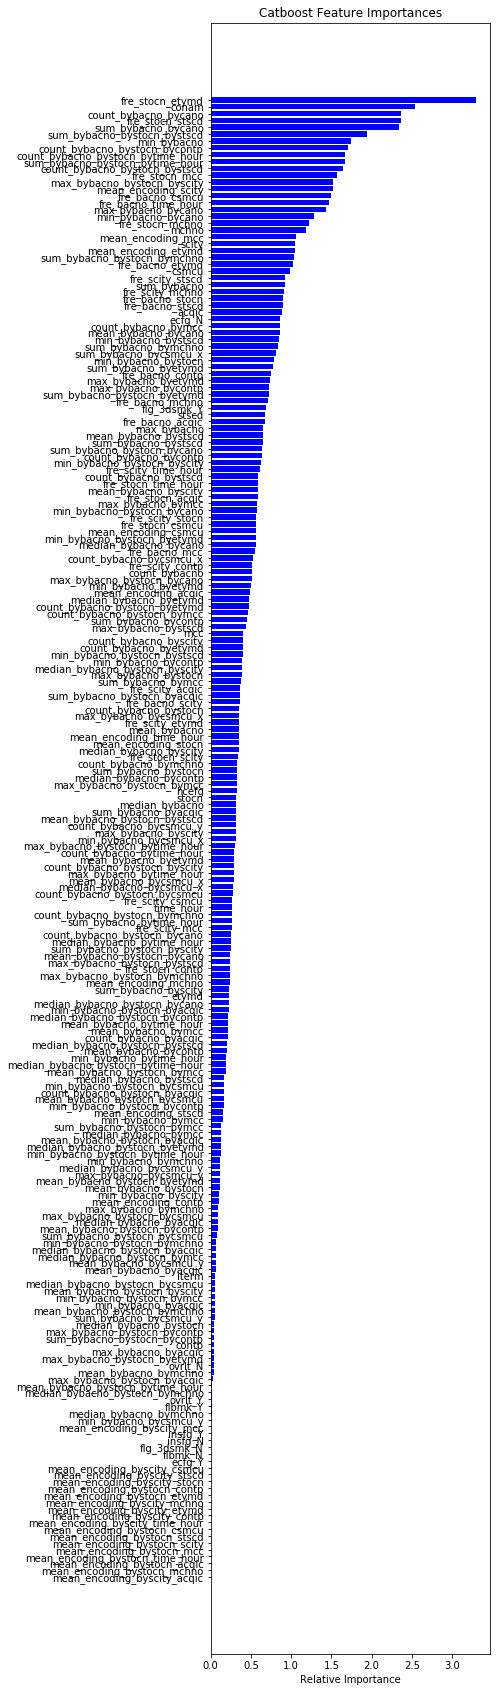

In [50]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = df_train_X.columns

plt.figure(figsize=(5,30)) # 調整長寬
plt.title('Catboost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [51]:
df_import = pd.DataFrame({'colname':df_train_X.columns,'importances':clf.feature_importances_}
            ).sort_values(by='importances',ascending=False)

In [53]:
#pro = np.array([])
#idx = np.array([])
#for i in range(len(pred_pro)):
#    pro = np.append(pro, pred_pro[i].reshape(-1))
#    idx = np.append(idx, te_index[i])
#idx = idx.astype(int)
#oof = pd.DataFrame()
#oof['pro'] = pro
#oof.index = idx
#oof = oof.sort_index()
#oof['txkey'] = train['txkey'].values

In [ ]:
oof.head()

In [ ]:
# oof.to_csv('oof_date.csv',index=None)

In [ ]:
meta_feature = pd.DataFrame()
meta_feature['txkey'] = test['txkey']
meta_feature['feature'] = np.mean(meta_y,axis=1)

In [ ]:
meta_feature.head()

In [ ]:
# meta_feature.to_csv('meta_feature_date.csv',index=None)

# 7. submission

In [54]:
df_train_y.fraud_ind.value_counts(normalize=True)

0    0.986676
1    0.013324
Name: fraud_ind, dtype: float64

In [55]:
## predict
predictions =  np.where(pred_pro4sub > 0.35,1,0)
pd.Series(predictions).value_counts(normalize=True)

0    0.987946
1    0.012054
dtype: float64

In [56]:
submission = pd.DataFrame({'txkey':df_test_id, 'fraud_ind': predictions})

In [57]:
submission.to_csv('submission_0714_v5_catbo.csv',index=None)